In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from hmmlearn import hmm

## Functions

### Weekly dataframes

In [34]:
def create_weekly_dataframes(df):
    # Convert index to datetime format if it's not already
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    # Find the first Monday and the last Sunday
    first_monday = df.index.min() - pd.DateOffset(days=df.index.min().dayofweek)
    last_sunday = df.index.max() + pd.DateOffset(days=6-df.index.max().dayofweek)
    
    # Create a dictionary to store dataframes for each week
    dataframes_by_week = {}

    # Iterate over each week and create a dataframe for it
    current_week_start = first_monday
    while current_week_start <= last_sunday:
        week_end = current_week_start + pd.DateOffset(days=6)
        week_data = df[(df.index >= current_week_start) & (df.index <= week_end)]
        
        if not week_data.empty:
            week_df = week_data.copy()
            week_range = f"{current_week_start.strftime('%Y-%m-%d')} to {week_end.strftime('%Y-%m-%d')}"
            dataframes_by_week[week_range] = week_df
        
        current_week_start += pd.DateOffset(weeks=1)
    
    return dataframes_by_week

In [35]:
def print_weekly_df(df):
    for week_range, week_df in df.items():
        print(f"Dataframe for week {week_range}:\n{week_df}\n")

### Daily dataframes

In [36]:
def create_dataframes_by_day(df):
    # Create a dictionary to store dataframes for each day
    dataframes_by_day = {}

    # Iterate over each unique day and create a dataframe for it
    for day in df['day'].unique():
        day_df = df[df['day'] == day].drop(columns='day').set_index(df[df['day'] == day].index)
        dataframes_by_day[day] = day_df

    return dataframes_by_day

In [37]:
def print_daily_df(df):
    for day, day_df in df.items():
        print(f"Dataframe for {day}:\n{day_df}\n")

### Appliance Usage

In [38]:
def pre_process(df,appliance_name):
    df = df.rename(columns={'power': f'{appliance_name}_electricity_consumption', 'time_reply': 'time'})
    df = df.drop(['time_request'], axis=1)
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df.set_index('time', inplace=True)
    df_cache = df.copy()
    df["change"] = df.iloc[:,0].diff()
    df = df[(df["change"] < -200) & (df.iloc[:,0] < 10)]
    df["day"] = df.index.day_name()
    resampled_df = df.copy()
    resampled_df['ti'] = pd.cut(
        resampled_df.index.hour * 60 + resampled_df.index.minute,
        bins=[0, 360, 720, 1080, 1440],
        labels=['0am-6am', '6am-12pm', '12pm-6pm', '6pm-12am'],
        include_lowest=True
    )
    df_processed = resampled_df.groupby([df.index.date, 'ti']).size().unstack(fill_value=0)
    return df_processed, df_cache

# ---------------------------------------------------------------------------------------------------------

### Microwave

In [39]:
df_mw = pd.read_csv("C:/Users/sanam/Documents/GeLaP/hh-07/label_002.csv")
df_mw_processed,df_mw_cache = pre_process(df_mw, 'microwave')

In [40]:
df_mw_processed

ti,0am-6am,6am-12pm,12pm-6pm,6pm-12am
2019-11-16,0,1,0,0


In [43]:
df_mw_cache

,microwave_electricity_consumption
time,
2019-10-21 16:40:00.259,3.0
2019-10-21 16:40:00.387,3.0
2019-10-21 16:40:00.510,3.1
2019-10-21 16:40:00.640,3.1
2019-10-21 16:40:00.810,3.1
...,...
2019-11-25 13:31:28.205,3.0
2019-11-25 13:31:28.327,3.0
2019-11-25 13:31:28.443,3.0


In [27]:
def hmm_function(df):
    # Extract the feature (consumption) for HMM training
    consumption = df.iloc[:,0].values.reshape(-1, 1)

    # Train a Hidden Markov Model
    model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=100)
    model.fit(consumption)

    # Predict hidden states using the trained model
    hidden_states = model.predict(consumption)

    # Find the indices where the hidden state changes (possible activations)
    activation_indices = np.where(np.diff(hidden_states) != 0)[0]

    # Get timestamps of device activations
    activated_timestamps = df.iloc[activation_indices + 1].index

    # Print timestamps of device activations
    for timestamp in activated_timestamps:
        print(f"Device activated at {timestamp}")


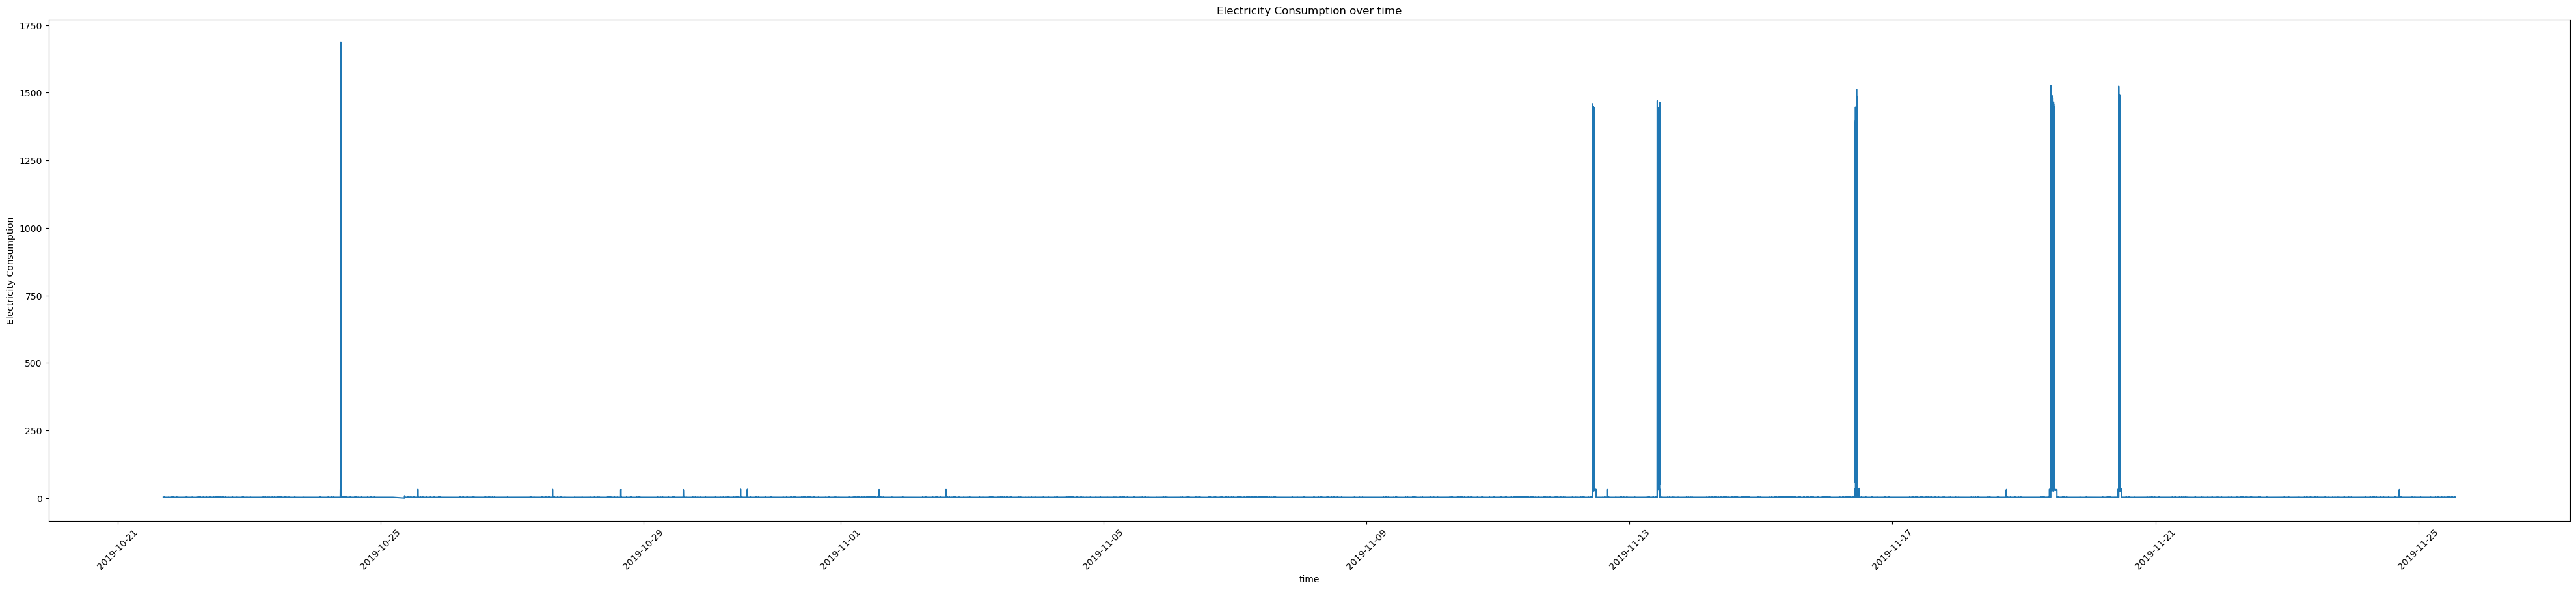

In [41]:
plt.figure(figsize=(50,10))
plt.plot(df_mw_cache.index, df_mw_cache['microwave_electricity_consumption'])
plt.xlabel('time')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption over time')
plt.xticks(rotation=45)
plt.show()

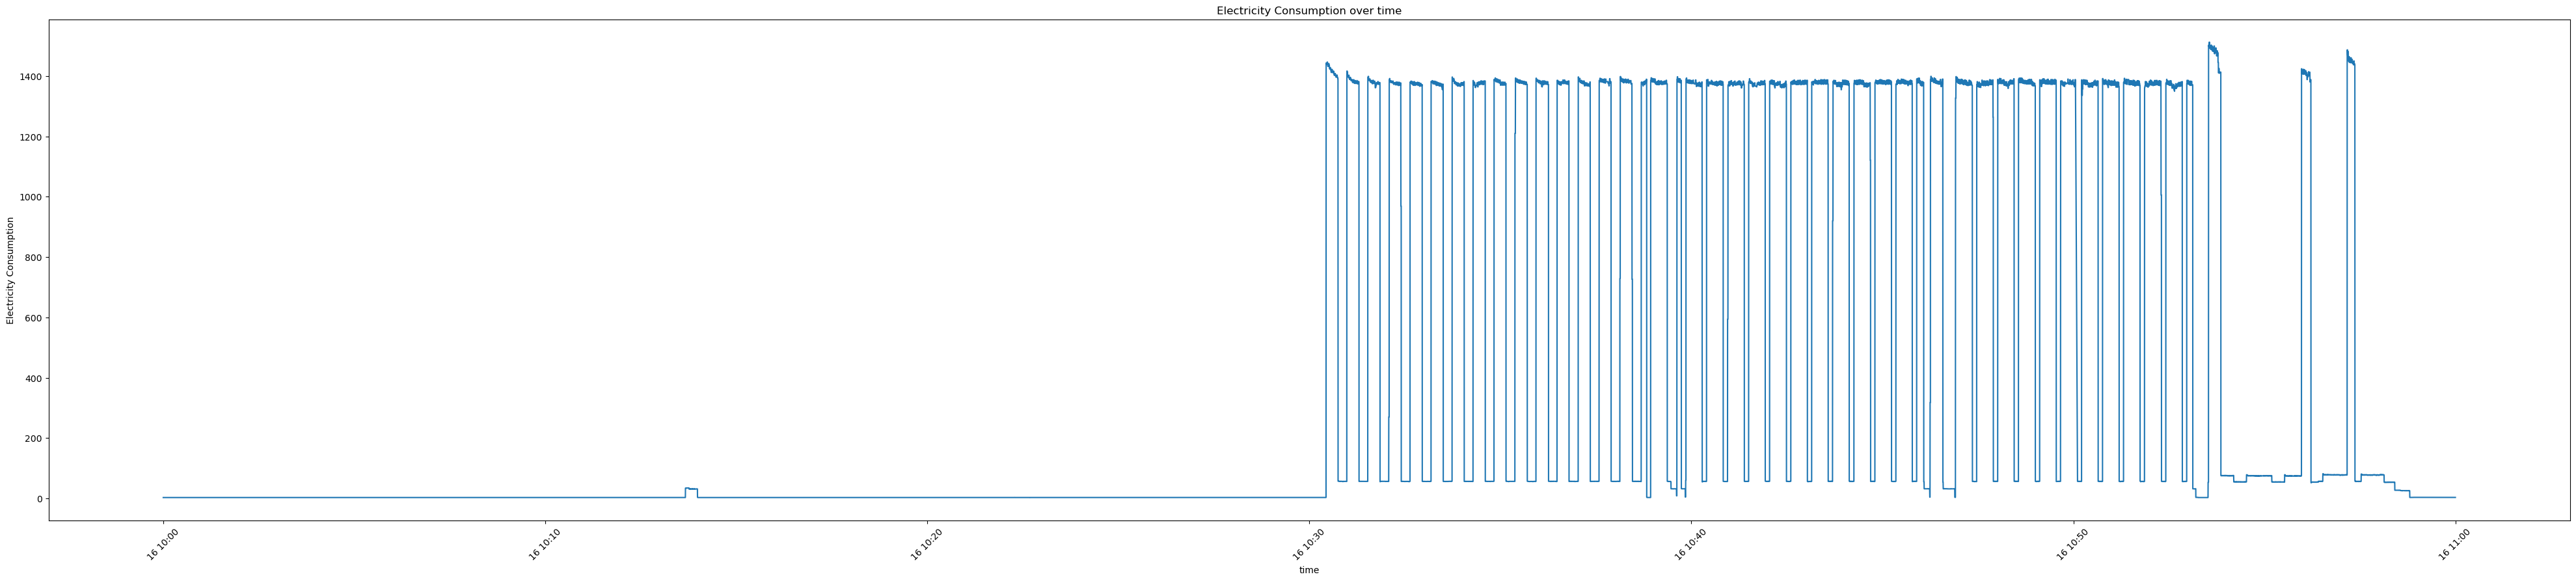

In [51]:
plt.figure(figsize=(50,10))
plt.plot(df_mw_cache.loc['2019-11-16 10'].index, df_mw_cache.loc['2019-11-16 10']['microwave_electricity_consumption'])
plt.xlabel('time')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption over time')
plt.xticks(rotation=45)
plt.show()

In [8]:
df_ek

ti,0am-6am,6am-12pm,12pm-6pm,6pm-12am
2019-10-21,0,0,2,4
2019-10-22,5,4,1,2
2019-10-23,2,1,1,0
2019-10-24,0,3,1,2
2019-10-25,0,4,1,1
2019-10-26,1,1,0,1
2019-10-27,0,3,1,1
2019-10-28,0,4,1,1
2019-10-29,0,6,1,1
2019-10-30,0,7,3,2


In [28]:
hmm_function(df_ek_cache)

Device activated at 2019-10-21 16:58:39.642000
Device activated at 2019-10-21 16:59:44.785000
Device activated at 2019-10-21 16:59:55.508000
Device activated at 2019-10-21 17:00:00.567000
Device activated at 2019-10-21 20:17:39.281000
Device activated at 2019-10-21 20:17:40.751000
Device activated at 2019-10-21 20:17:48.306000
Device activated at 2019-10-21 20:18:10.006000
Device activated at 2019-10-21 20:35:51.823000
Device activated at 2019-10-21 20:36:09.028000
Device activated at 2019-10-21 21:34:28.843000
Device activated at 2019-10-21 21:34:56.815000
Device activated at 2019-10-22 05:16:24.315000
Device activated at 2019-10-22 05:16:35.230000
Device activated at 2019-10-22 05:43:52.316000
Device activated at 2019-10-22 05:48:21.198000
Device activated at 2019-10-22 05:50:24.665000
Device activated at 2019-10-22 05:50:33.669000
Device activated at 2019-10-22 05:54:25.876000
Device activated at 2019-10-22 05:54:37.635000
Device activated at 2019-10-22 06:00:35.716000
Device activa

In [41]:
df_ek = pd.read_csv("C:/Users/sanam/Documents/GeLaP/hh-07/label_003.csv")
df_ek = df_ek.rename(columns={'power': 'electric_kettle_electricity_consumption', 'time_reply': 'time'})
df_ek = df_ek.drop(['time_request'], axis=1)
df_ek['time'] = pd.to_datetime(df_ek['time'], unit='ms')

In [42]:
df_ek.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18811083 entries, 0 to 18811082
Data columns (total 2 columns):
 #   Column                                   Dtype         
---  ------                                   -----         
 0   time                                     datetime64[ns]
 1   electric_kettle_electricity_consumption  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 287.0 MB


In [43]:
df_ek.set_index('time', inplace=True)

In [44]:
df_ek

,electric_kettle_electricity_consumption
time,
2019-10-21 16:40:00.166,0.2
2019-10-21 16:40:00.302,0.3
2019-10-21 16:40:00.443,0.3
2019-10-21 16:40:00.569,0.3
2019-10-21 16:40:00.741,0.3
...,...
2019-11-25 13:31:28.105,0.3
2019-11-25 13:31:28.295,0.3
2019-11-25 13:31:28.457,0.3


In [170]:
df_ek.iloc[:,0].diff()

time
2019-10-21 16:40:00.166    NaN
2019-10-21 16:40:00.302    0.1
2019-10-21 16:40:00.443    0.0
2019-10-21 16:40:00.569    0.0
2019-10-21 16:40:00.741    0.0
                          ... 
2019-11-25 13:31:28.105    0.0
2019-11-25 13:31:28.295    0.0
2019-11-25 13:31:28.457    0.0
2019-11-25 13:31:28.641    0.0
2019-11-25 13:31:28.788    0.0
Name: electric_kettle_electricity_consumption, Length: 18811083, dtype: float64

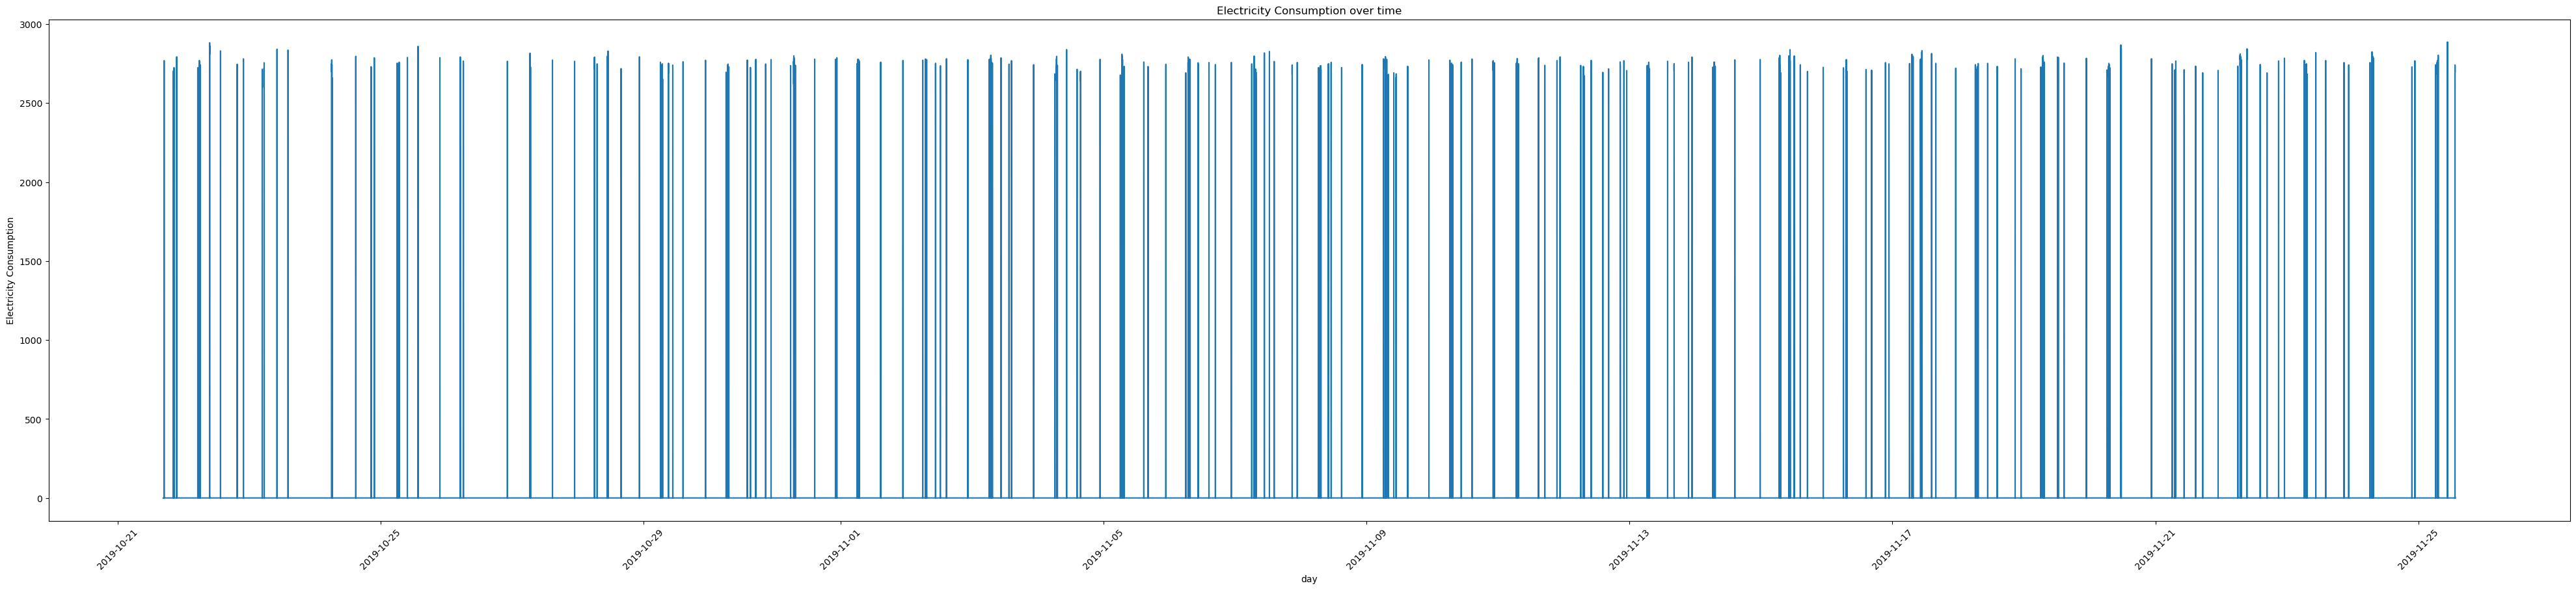

In [45]:
plt.figure(figsize=(50,10))
plt.plot(df_ek.index, df_ek['electric_kettle_electricity_consumption'])
plt.xlabel('day')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption over time')
plt.xticks(rotation=45)
plt.show()

In [47]:
df_ek_copy = df_ek.copy()

In [48]:
df_ek_copy["change"] = df_ek_copy['electric_kettle_electricity_consumption'].diff()

In [49]:
df_ek_copy = df_ek_copy[(df_ek_copy["change"] < -200) & (df_ek["electric_kettle_electricity_consumption"] < 10)]

In [50]:
df_ek_copy

,electric_kettle_electricity_consumption,change
time,,
2019-10-21 16:59:44.785,0.5,-2719.5
2019-10-21 17:00:00.567,0.4,-2723.0
2019-10-21 20:17:40.751,0.3,-2673.0
2019-10-21 20:18:10.006,0.3,-2644.2
2019-10-21 20:36:09.028,0.0,-2678.6
...,...,...
2019-11-25 07:01:22.114,0.7,-2754.6
2019-11-25 07:07:17.509,0.2,-2666.1
2019-11-25 07:16:02.446,0.3,-2777.6


In [51]:
df_ek_copy["day"] = df_ek_copy.index.day_name()

C:\Users\sanam\AppData\Local\Temp\ipykernel_17568\1733461895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ek_copy["day"] = df_ek_copy.index.day_name()


In [52]:
df_ek_copy

,electric_kettle_electricity_consumption,change,day
time,,,
2019-10-21 16:59:44.785,0.5,-2719.5,Monday
2019-10-21 17:00:00.567,0.4,-2723.0,Monday
2019-10-21 20:17:40.751,0.3,-2673.0,Monday
2019-10-21 20:18:10.006,0.3,-2644.2,Monday
2019-10-21 20:36:09.028,0.0,-2678.6,Monday
...,...,...,...
2019-11-25 07:01:22.114,0.7,-2754.6,Monday
2019-11-25 07:07:17.509,0.2,-2666.1,Monday
2019-11-25 07:16:02.446,0.3,-2777.6,Monday


In [104]:
df_ek_copy.index

DatetimeIndex(['2019-10-21 16:59:44.785000', '2019-10-21 17:00:00.567000',
               '2019-10-21 20:17:40.751000', '2019-10-21 20:18:10.006000',
               '2019-10-21 20:36:09.028000', '2019-10-21 21:34:56.815000',
               '2019-10-22 05:16:35.230000', '2019-10-22 05:48:21.198000',
               '2019-10-22 05:50:33.669000', '2019-10-22 05:54:37.635000',
               ...
               '2019-11-24 21:39:51.786000', '2019-11-24 22:44:39.114000',
               '2019-11-25 06:15:23.157000', '2019-11-25 06:55:28.765000',
               '2019-11-25 06:57:38.029000', '2019-11-25 07:01:22.114000',
               '2019-11-25 07:07:17.509000', '2019-11-25 07:16:02.446000',
               '2019-11-25 10:38:12.154000', '2019-11-25 13:23:48.089000'],
              dtype='datetime64[ns]', name='time', length=334, freq=None)

In [59]:
type(df_ek_copy["day"])

pandas.core.series.Series

In [63]:
df_ek_days = df_ek_copy.groupby("day")

In [64]:
df_ek_days

In [129]:
resampled_df = df_ek_copy.copy()
resampled_df['ti'] = pd.cut(
    resampled_df.index.hour * 60 + resampled_df.index.minute,
    bins=[0, 360, 720, 1080, 1440],
    labels=['0am-6am', '6am-12pm', '12pm-6pm', '6pm-12am'],
    include_lowest=True
)
result_ek = resampled_df.groupby([df_ek_copy.index.date, 'ti']).size().unstack(fill_value=0)

In [130]:
resampled_df

,electric_kettle_electricity_consumption,change,day,ti
time,,,,
2019-10-21 16:59:44.785,0.5,-2719.5,Monday,12pm-6pm
2019-10-21 17:00:00.567,0.4,-2723.0,Monday,12pm-6pm
2019-10-21 20:17:40.751,0.3,-2673.0,Monday,6pm-12am
2019-10-21 20:18:10.006,0.3,-2644.2,Monday,6pm-12am
2019-10-21 20:36:09.028,0.0,-2678.6,Monday,6pm-12am
...,...,...,...,...
2019-11-25 07:01:22.114,0.7,-2754.6,Monday,6am-12pm
2019-11-25 07:07:17.509,0.2,-2666.1,Monday,6am-12pm
2019-11-25 07:16:02.446,0.3,-2777.6,Monday,6am-12pm


In [131]:
result_ek

ti,0am-6am,6am-12pm,12pm-6pm,6pm-12am
2019-10-21,0,0,2,4
2019-10-22,5,4,1,2
2019-10-23,2,1,1,0
2019-10-24,0,3,1,2
2019-10-25,0,4,1,1
2019-10-26,1,1,0,1
2019-10-27,0,3,1,1
2019-10-28,0,4,1,1
2019-10-29,0,6,1,1
2019-10-30,0,7,3,2


In [134]:
result_ek.index = pd.to_datetime(result_ek.index)

In [137]:
result_ek["day"] = result_ek.index.day_name()

In [138]:
result_ek

ti,0am-6am,6am-12pm,12pm-6pm,6pm-12am,day
2019-10-21,0,0,2,4,Monday
2019-10-22,5,4,1,2,Tuesday
2019-10-23,2,1,1,0,Wednesday
2019-10-24,0,3,1,2,Thursday
2019-10-25,0,4,1,1,Friday
2019-10-26,1,1,0,1,Saturday
2019-10-27,0,3,1,1,Sunday
2019-10-28,0,4,1,1,Monday
2019-10-29,0,6,1,1,Tuesday
2019-10-30,0,7,3,2,Wednesday


In [141]:
dataframes_by_day = {}

# Iterate over each unique day and create a dataframe for it
for day in result_ek['day'].unique():
    day_df = result_ek[result_ek['day'] == day].drop(columns='day').set_index(result_ek[result_ek['day'] == day].index)
    dataframes_by_day[day] = day_df

# Print the dataframes for each day
for day, day_df in dataframes_by_day.items():
    print(f"Dataframe for {day}:\n{day_df}\n")

Dataframe for Monday:
ti          0am-6am  6am-12pm  12pm-6pm  6pm-12am
2019-10-21        0         0         2         4
2019-10-28        0         4         1         1
2019-11-04        0         4         2         1
2019-11-11        0         6         4         2
2019-11-18        0         5         1         3
2019-11-25        0         7         1         0

Dataframe for Tuesday:
ti          0am-6am  6am-12pm  12pm-6pm  6pm-12am
2019-10-22        5         4         1         2
2019-10-29        0         6         1         1
2019-11-05        0         7         2         1
2019-11-12        0         7         2         3
2019-11-19        0         6         4         1

Dataframe for Wednesday:
ti          0am-6am  6am-12pm  12pm-6pm  6pm-12am
2019-10-23        2         1         1         0
2019-10-30        0         7         3         2
2019-11-06        1         7         2         1
2019-11-13        0         6         2         2
2019-11-20        0        1

In [158]:
df_by_week = create_weekly_dataframes(result_ek)

In [159]:
for week_range, week_df in df_by_week.items():
    print(f"Dataframe for week {week_range}:\n{week_df}\n")

Dataframe for week 2019-10-21 to 2019-10-27:
ti          0am-6am  6am-12pm  12pm-6pm  6pm-12am        day
2019-10-21        0         0         2         4     Monday
2019-10-22        5         4         1         2    Tuesday
2019-10-23        2         1         1         0  Wednesday
2019-10-24        0         3         1         2   Thursday
2019-10-25        0         4         1         1     Friday
2019-10-26        1         1         0         1   Saturday
2019-10-27        0         3         1         1     Sunday

Dataframe for week 2019-10-28 to 2019-11-03:
ti          0am-6am  6am-12pm  12pm-6pm  6pm-12am        day
2019-10-28        0         4         1         1     Monday
2019-10-29        0         6         1         1    Tuesday
2019-10-30        0         7         3         2  Wednesday
2019-10-31        1         5         1         2   Thursday
2019-11-01        1         5         1         1     Friday
2019-11-02        1         3         3         2   Sat

## 2019-10-22

In [55]:
limited_df = df_ek.loc["2019-10-22"]

In [56]:
limited_df

,electric_kettle_electricity_consumption
time,
2019-10-22 00:00:00.067,0.3
2019-10-22 00:00:00.206,0.3
2019-10-22 00:00:00.360,0.3
2019-10-22 00:00:00.507,0.3
2019-10-22 00:00:00.662,0.3
...,...
2019-10-22 23:59:59.407,0.3
2019-10-22 23:59:59.542,0.3
2019-10-22 23:59:59.705,0.3


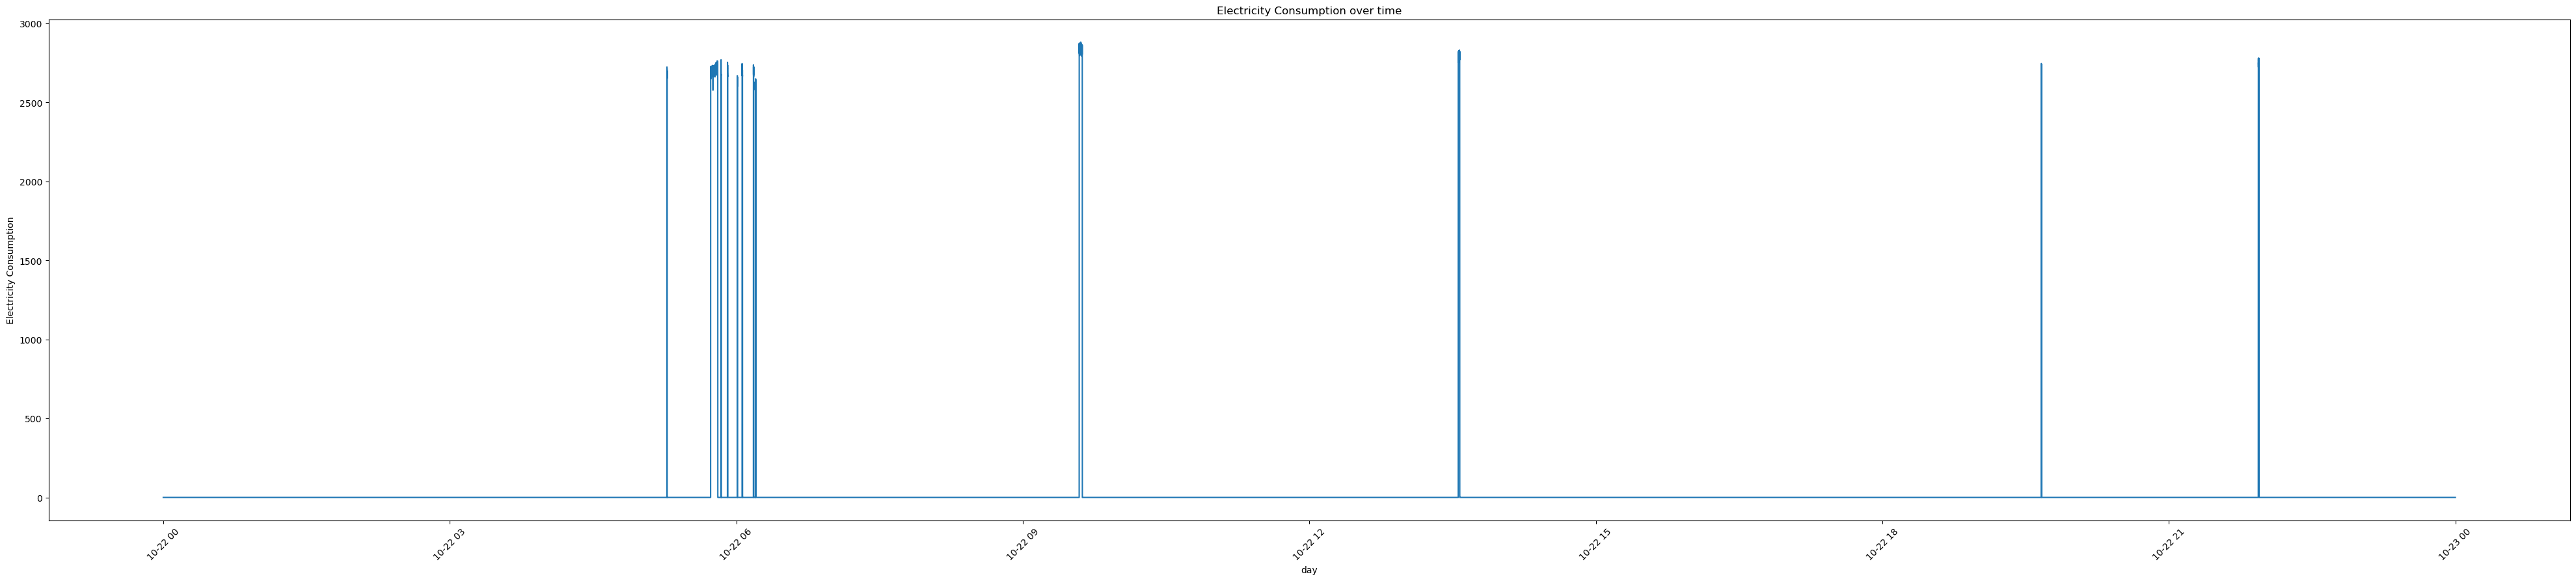

In [57]:
plt.figure(figsize=(50,10))
plt.plot(limited_df.index, limited_df['electric_kettle_electricity_consumption'])
plt.xlabel('day')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption over time')
plt.xticks(rotation=45)
plt.show()

In [58]:
limited_df["change"] = limited_df['electric_kettle_electricity_consumption'].diff()

In [137]:
limited_df = limited_df[(limited_df["change"] < -200) & (limited_df["electric_kettle_electricity_consumption"] < 10)]

In [138]:
limited_df.shape

(12, 2)

## 2019-10-23 Thrusday

In [87]:
df_ek_tuesday

,electric_kettle_electricity_consumption,change,day
time,,,
2019-10-22 05:16:35.230,0.1,-2647.3,Tuesday
2019-10-22 05:48:21.198,0.3,-2647.6,Tuesday
2019-10-22 05:50:33.669,0.1,-2675.2,Tuesday
2019-10-22 05:54:37.635,0.2,-1096.0,Tuesday
2019-10-22 06:00:46.171,0.5,-2598.9,Tuesday
2019-10-22 06:03:53.388,0.4,-2668.3,Tuesday
2019-10-22 06:10:58.017,0.3,-656.5,Tuesday
2019-10-22 06:12:19.214,0.1,-2595.4,Tuesday
2019-10-22 09:37:23.005,0.3,-2862.1,Tuesday


In [131]:
limited_df2=df_ek.loc["2019-10-23"]

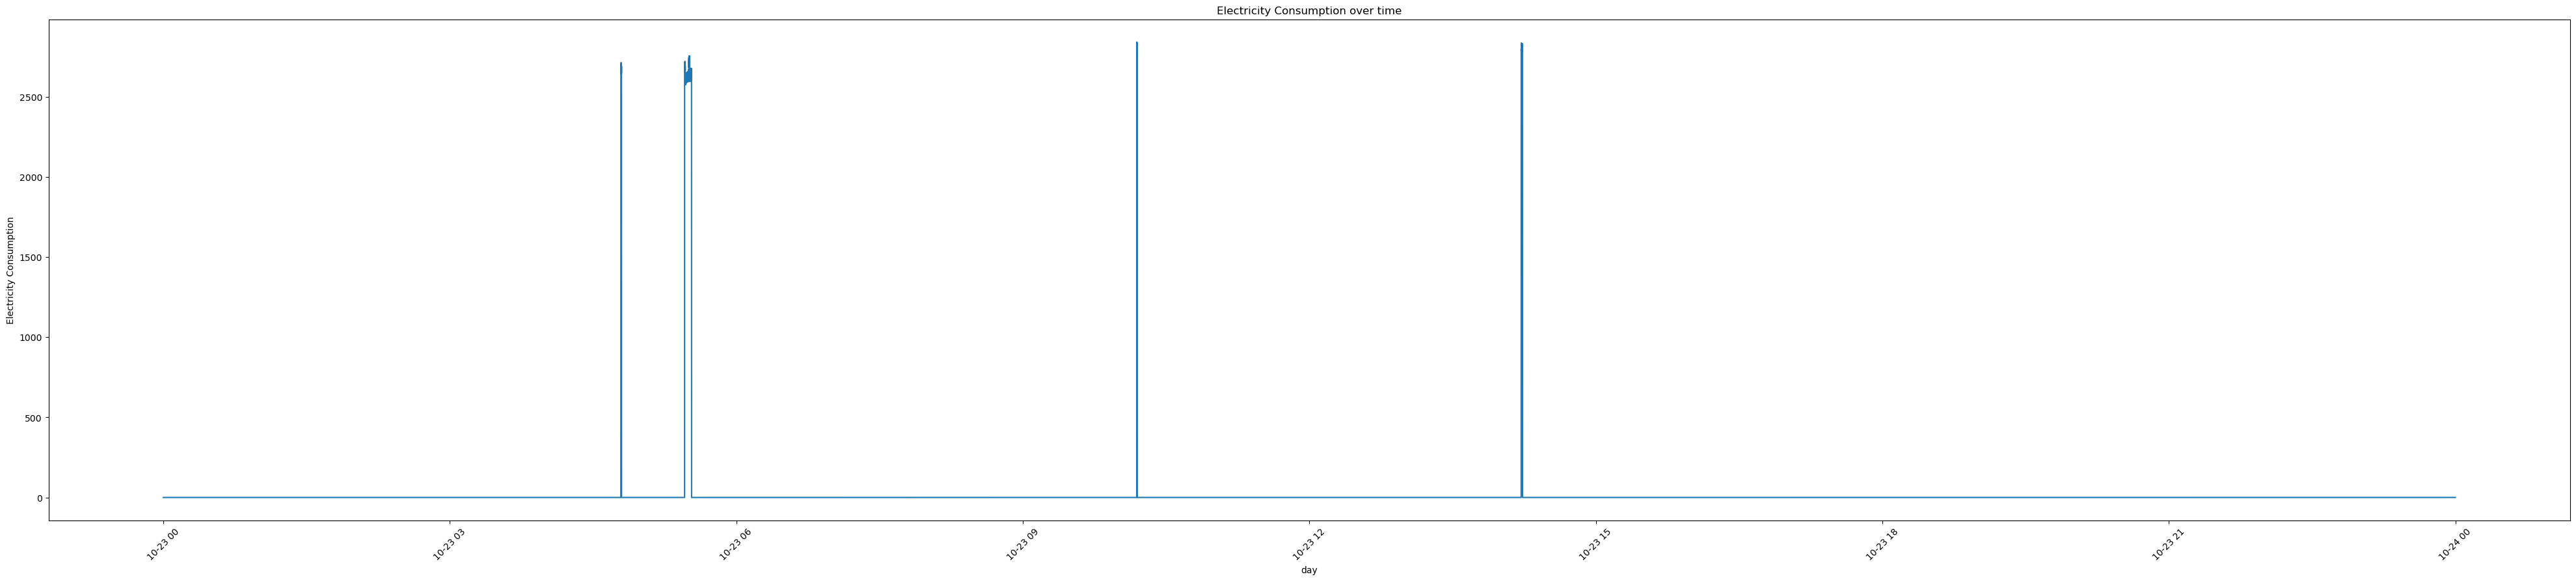

In [132]:
plt.figure(figsize=(50,10))
plt.plot(limited_df2.index, limited_df2['electric_kettle_electricity_consumption'])
plt.xlabel('day')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption over time')
plt.xticks(rotation=45)
plt.show()

In [140]:
limited_df2["change"] = limited_df2['electric_kettle_electricity_consumption'].diff()

In [141]:
limited_df2 = limited_df2[(limited_df2["change"] < -200) & (limited_df2["electric_kettle_electricity_consumption"] < 10)]

In [142]:
limited_df2

,electric_kettle_electricity_consumption,change
time,,
2019-10-23 04:47:52.651,0.3,-2691.3
2019-10-23 05:31:52.663,0.3,-1108.7
2019-10-23 10:11:51.670,0.2,-2787.6
2019-10-23 14:13:54.373,0.3,-2783.5


## 2019-10-24 Friday

In [144]:
limited_df3=df_ek.loc["2019-10-24"]

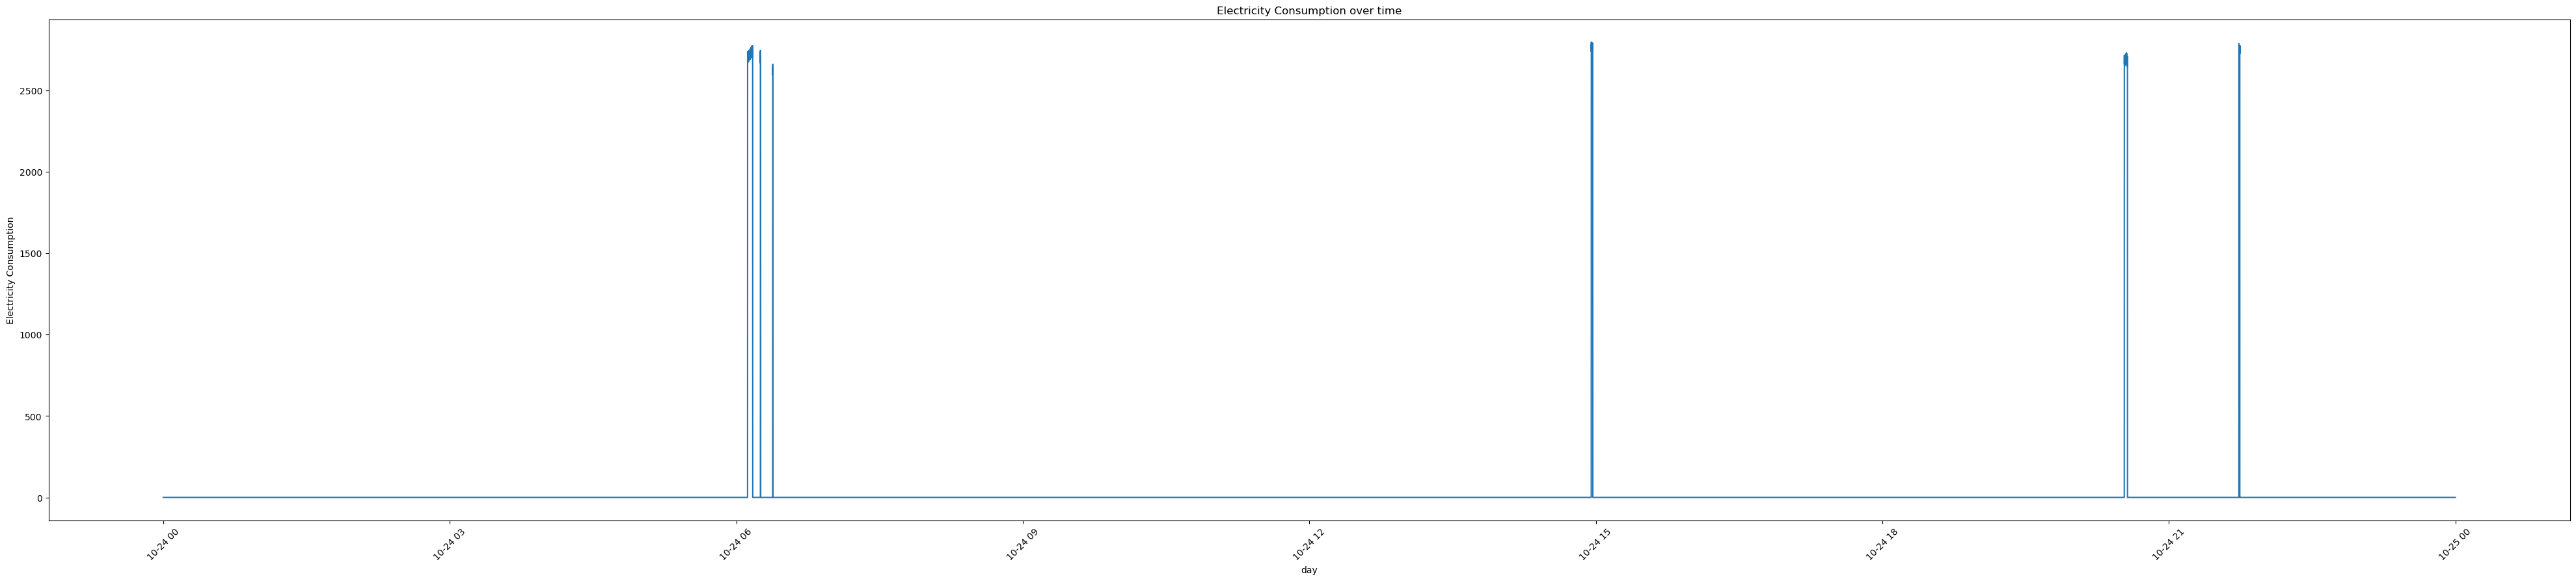

In [145]:
plt.figure(figsize=(50,10))
plt.plot(limited_df3.index, limited_df3['electric_kettle_electricity_consumption'])
plt.xlabel('day')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption over time')
plt.xticks(rotation=45)
plt.show()

In [146]:
limited_df3["change"] = limited_df3['electric_kettle_electricity_consumption'].diff()

In [147]:
limited_df3 = limited_df3[(limited_df3["change"] < -200) & (limited_df3["electric_kettle_electricity_consumption"] < 10)]

In [148]:
limited_df3

,electric_kettle_electricity_consumption,change
time,,
2019-10-24 06:10:17.579,2.4,-2747.7
2019-10-24 06:15:19.009,0.4,-331.4
2019-10-24 06:23:04.456,0.0,-2590.8
2019-10-24 14:58:03.168,0.4,-2765.3
2019-10-24 20:33:59.253,0.2,-2703.9
2019-10-24 21:44:33.289,0.4,-2728.6


## 2019-10-25 Saturday

In [150]:
limited_df4=df_ek.loc["2019-10-25"]

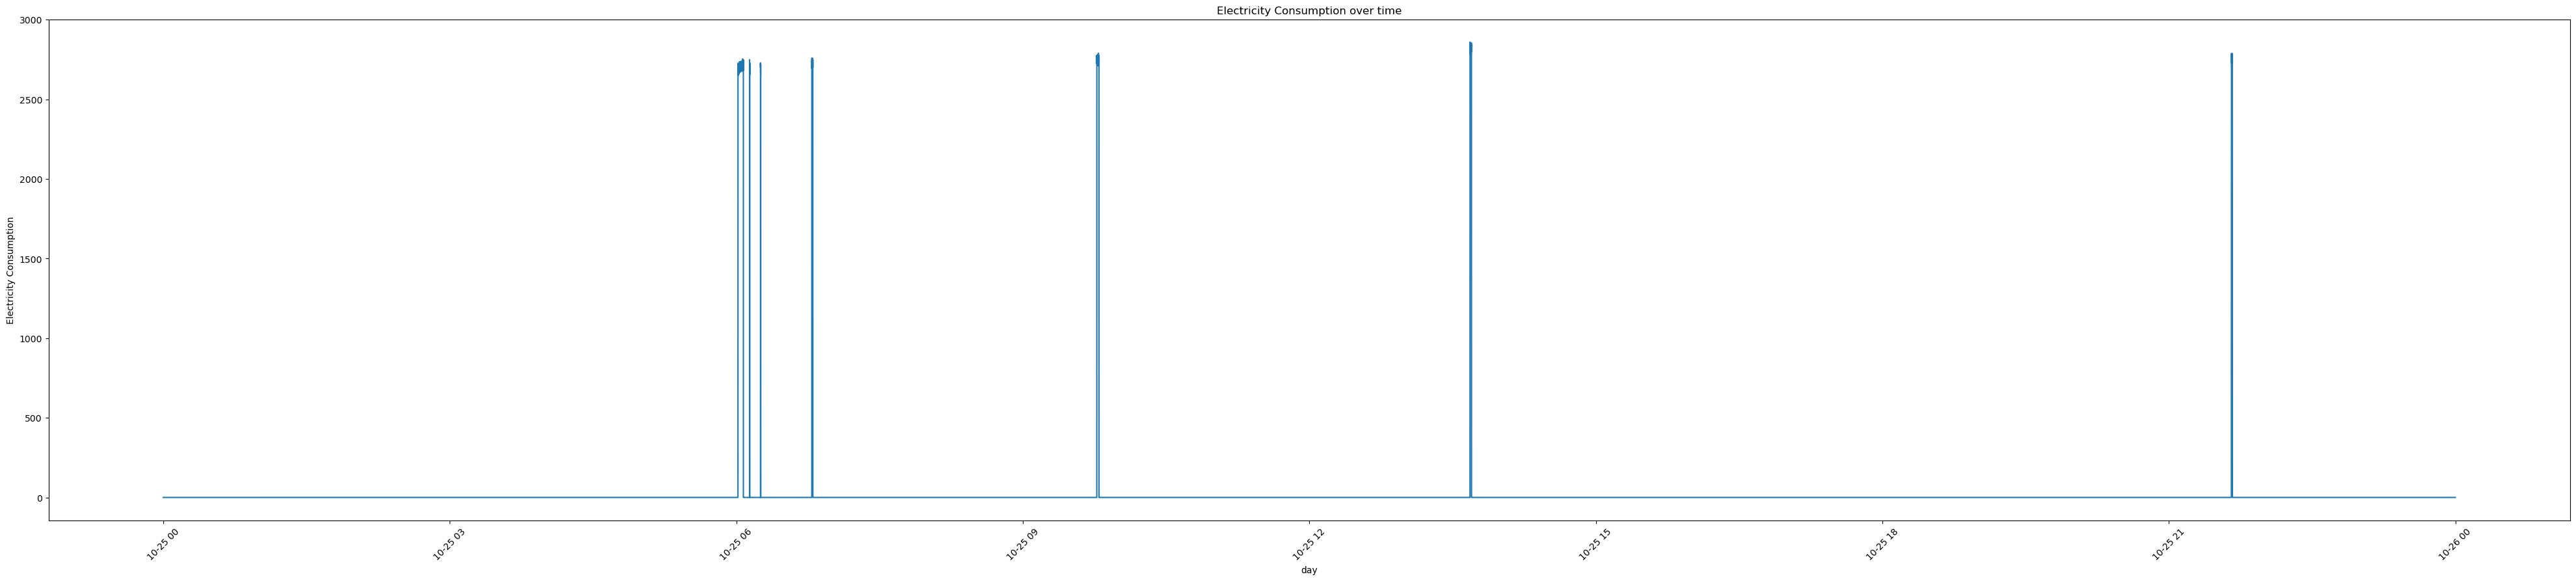

In [151]:
plt.figure(figsize=(50,10))
plt.plot(limited_df4.index, limited_df4['electric_kettle_electricity_consumption'])
plt.xlabel('day')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption over time')
plt.xticks(rotation=45)
plt.show()

In [152]:
limited_df4["change"] = limited_df4['electric_kettle_electricity_consumption'].diff()

In [154]:
limited_df4 = limited_df4[(limited_df4["change"] < -200) & (limited_df4["electric_kettle_electricity_consumption"] < 10)]

In [155]:
limited_df4

,electric_kettle_electricity_consumption,change
time,,
2019-10-25 06:04:26.540,0.0,-2747.8
2019-10-25 06:08:29.391,1.9,-2722.0
2019-10-25 06:48:05.147,0.2,-2745.8
2019-10-25 09:47:53.347,0.2,-2754.7
2019-10-25 13:41:52.307,0.3,-2805.2
2019-10-25 21:39:52.088,0.8,-2736.4


## 2019-10-26 Sunday

In [156]:
limited_df5=df_ek.loc["2019-10-26"]

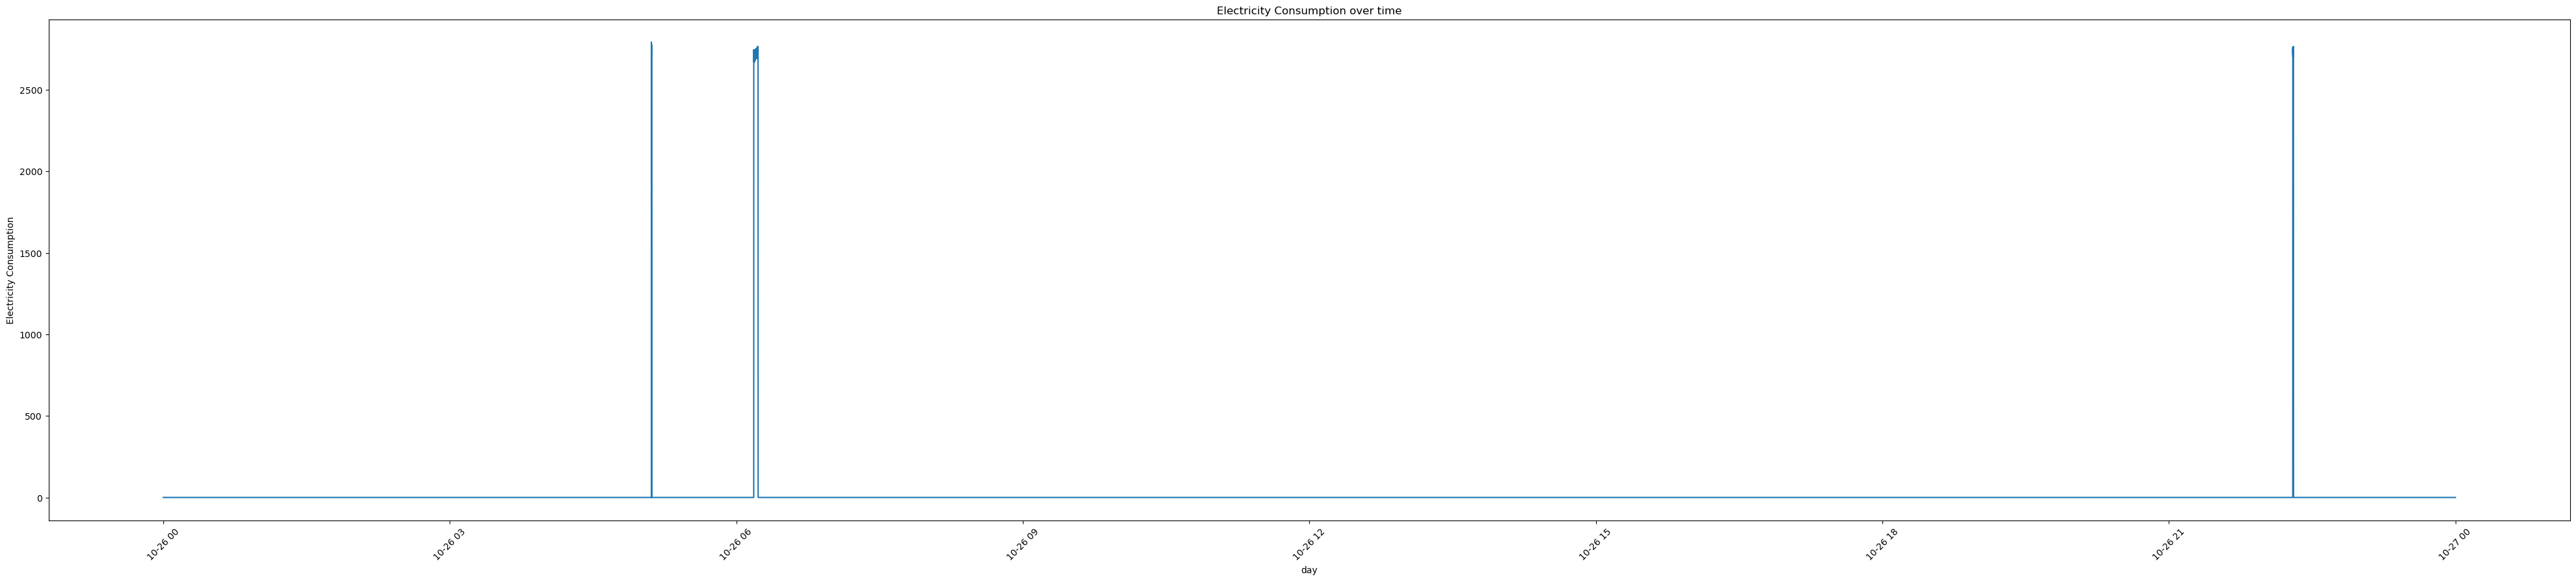

In [157]:
plt.figure(figsize=(50,10))
plt.plot(limited_df5.index, limited_df5['electric_kettle_electricity_consumption'])
plt.xlabel('day')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption over time')
plt.xticks(rotation=45)
plt.show()

## 2019-10-27 Monday

In [158]:
limited_df6=df_ek.loc["2019-10-27"]

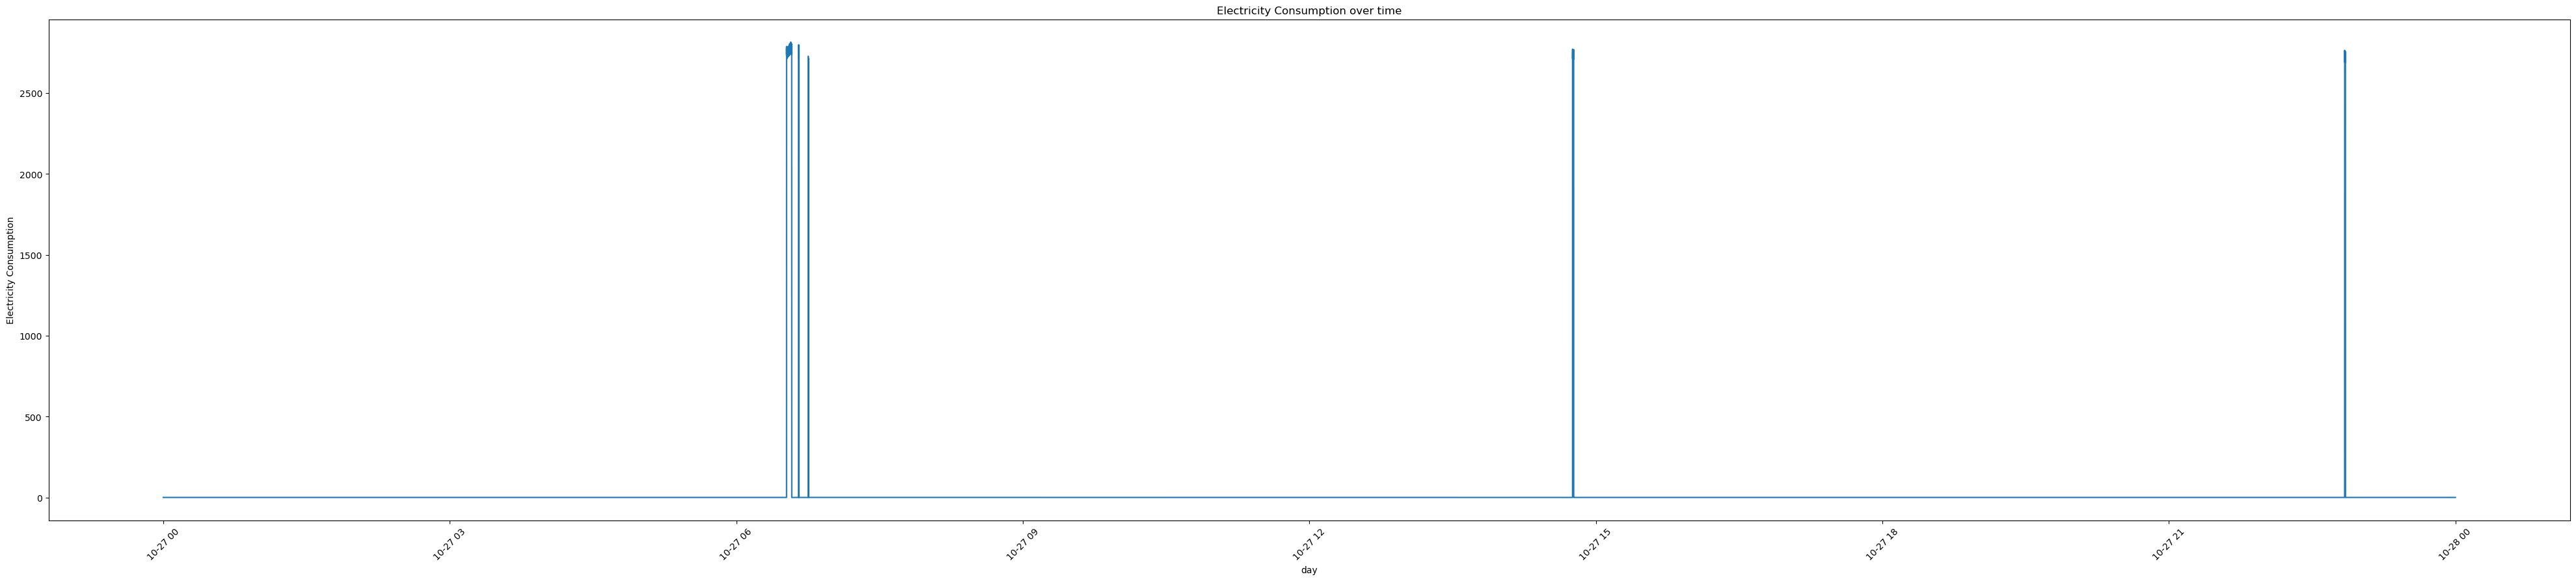

In [159]:
plt.figure(figsize=(50,10))
plt.plot(limited_df6.index, limited_df6['electric_kettle_electricity_consumption'])
plt.xlabel('day')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption over time')
plt.xticks(rotation=45)
plt.show()

## 2019-10-28 Tuesday

In [160]:
limited_df7=df_ek.loc["2019-10-28"]

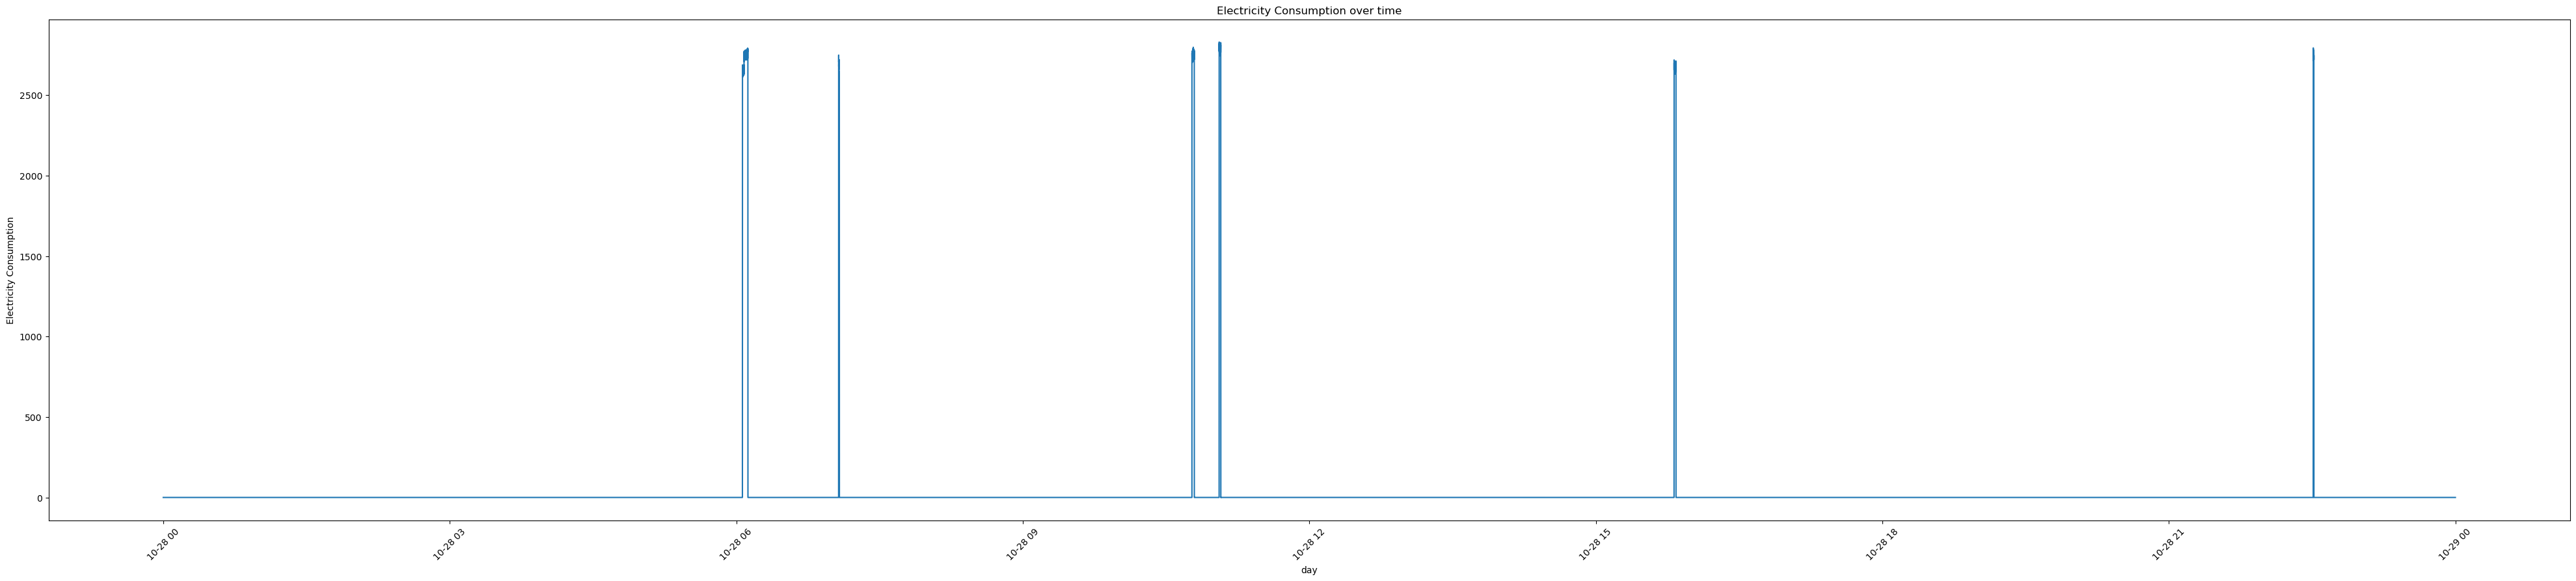

In [161]:
plt.figure(figsize=(50,10))
plt.plot(limited_df7.index, limited_df7['electric_kettle_electricity_consumption'])
plt.xlabel('day')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption over time')
plt.xticks(rotation=45)
plt.show()

## 2019-10-29 Wednesday

In [163]:
limited_df8=df_ek.loc["2019-10-29"]

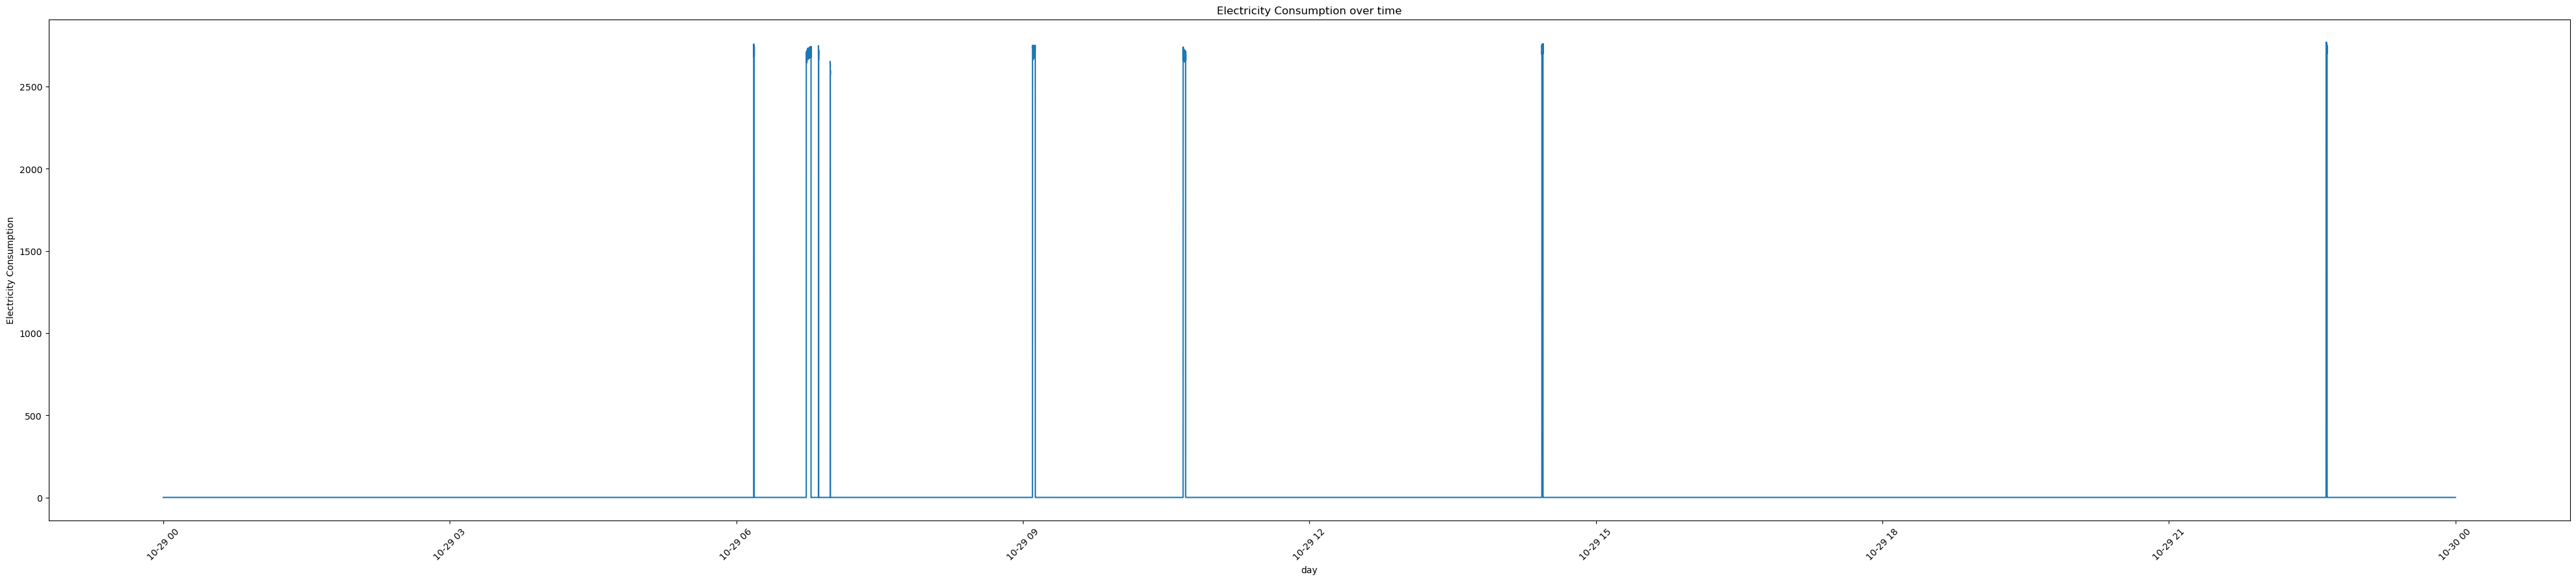

In [164]:
plt.figure(figsize=(50,10))
plt.plot(limited_df8.index, limited_df8['electric_kettle_electricity_consumption'])
plt.xlabel('day')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption over time')
plt.xticks(rotation=45)
plt.show()

### 1min avg

In [7]:
df_ek_1avg = df_ek.resample('1T').mean()
df_ek_1avg.reset_index(inplace = True)

In [8]:
df_ek_1avg

,time,electric_kettle_electricity_consumption
0,2019-10-21 16:40:00,0.306077
1,2019-10-21 16:41:00,0.301120
2,2019-10-21 16:42:00,0.296491
3,2019-10-21 16:43:00,0.301397
4,2019-10-21 16:44:00,0.299164
...,...,...
50207,2019-11-25 13:27:00,0.304261
50208,2019-11-25 13:28:00,0.296784
50209,2019-11-25 13:29:00,0.297995
50210,2019-11-25 13:30:00,0.301882


In [46]:
desired_day_df = df_ek_1avg[df_ek_1avg['time'].dt.date == pd.to_datetime("2019-10-22").date()]

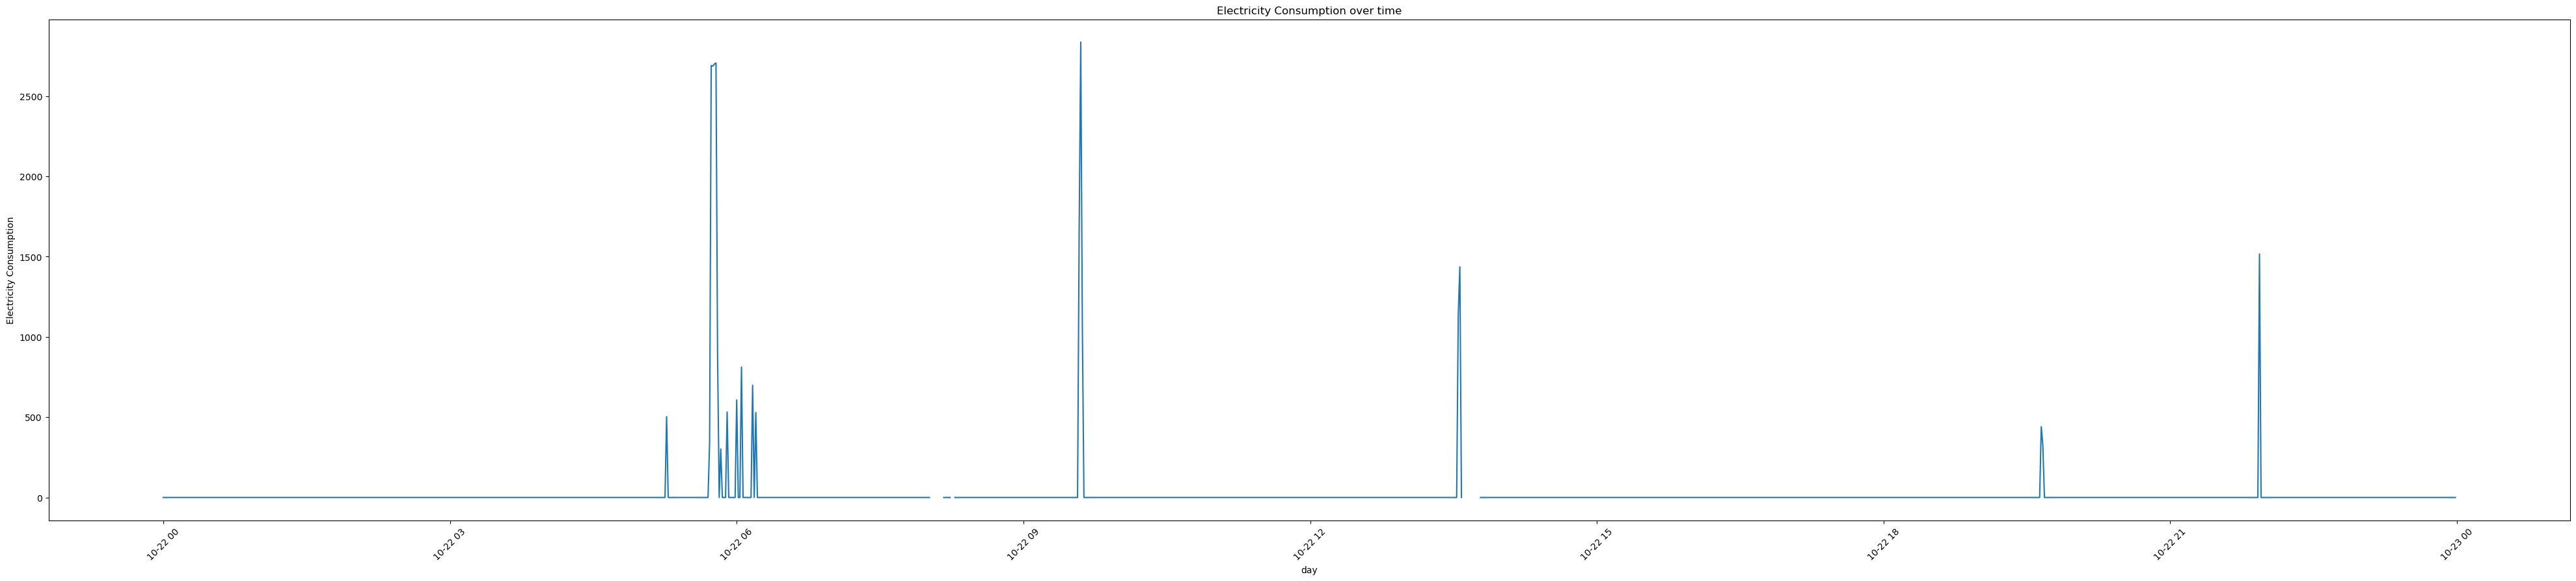

In [47]:
plt.figure(figsize=(50,10))
plt.plot(desired_day_df['time'], desired_day_df['electric_kettle_electricity_consumption'])
plt.xlabel('day')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption over time')
plt.xticks(rotation=45)
plt.show()

In [48]:
fig = px.line(desired_day_df, x='time', y='electric_kettle_electricity_consumption', title='Elektric Kettle')
fig.show()

In [49]:
desired_day_df

,time,electric_kettle_electricity_consumption
440,2019-10-22 00:00:00,0.306150
441,2019-10-22 00:01:00,0.302514
442,2019-10-22 00:02:00,0.296273
443,2019-10-22 00:03:00,0.297941
444,2019-10-22 00:04:00,0.301159
...,...,...
1875,2019-10-22 23:55:00,0.302835
1876,2019-10-22 23:56:00,0.301108
1877,2019-10-22 23:57:00,0.304267
1878,2019-10-22 23:58:00,0.311346


In [50]:
desired_day_df["change"] = desired_day_df["electric_kettle_electricity_consumption"].diff()

/tmp/ipykernel_552456/3681714865.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
desired_day_df = desired_day_df[desired_day_df["change"] < -1]

In [65]:
desired_day_df.shape

(16, 3)

In [66]:
desired_day_df

,time,electric_kettle_electricity_consumption,change
757,2019-10-22 05:17:00,0.301662,-503.386589
785,2019-10-22 05:45:00,2686.771429,-3.247013
788,2019-10-22 05:48:00,889.795935,-1816.405360
789,2019-10-22 05:49:00,0.291192,-889.504743
791,2019-10-22 05:51:00,0.291089,-301.810964
795,2019-10-22 05:55:00,0.297778,-532.501609
801,2019-10-22 06:01:00,0.288166,-607.182320
804,2019-10-22 06:04:00,0.294428,-812.017214
811,2019-10-22 06:11:00,0.287135,-698.661359
813,2019-10-22 06:13:00,0.300000,-528.844764


In [139]:
limited_df

,electric_kettle_electricity_consumption,change
time,,
2019-10-22 05:16:35.230,0.1,-2647.3
2019-10-22 05:48:21.198,0.3,-2647.6
2019-10-22 05:50:33.669,0.1,-2675.2
2019-10-22 05:54:37.635,0.2,-1096.0
2019-10-22 06:00:46.171,0.5,-2598.9
2019-10-22 06:03:53.388,0.4,-2668.3
2019-10-22 06:10:58.017,0.3,-656.5
2019-10-22 06:12:19.214,0.1,-2595.4
2019-10-22 09:37:23.005,0.3,-2862.1


In [130]:
df_ek.loc["2019-10-22 06:00:46"]

,electric_kettle_electricity_consumption
time,
2019-10-22 06:00:46.033,2599.4
2019-10-22 06:00:46.171,0.5
2019-10-22 06:00:46.297,0.5
2019-10-22 06:00:46.425,0.5
2019-10-22 06:00:46.602,0.5
2019-10-22 06:00:46.718,0.3


# Floorlamp Kitchen

In [72]:
df_fl = pd.read_csv("/home/sm04323/GeLapDataset/gelap-master/hh-07/label_005.csv")
df_fl = df_fl.rename(columns={'power': 'floor_lamp_electricity_consumption', 'time_reply': 'time'})
df_fl = df_fl.drop(['time_request'], axis=1)
df_fl['time'] = pd.to_datetime(df_fl['time'], unit='ms')

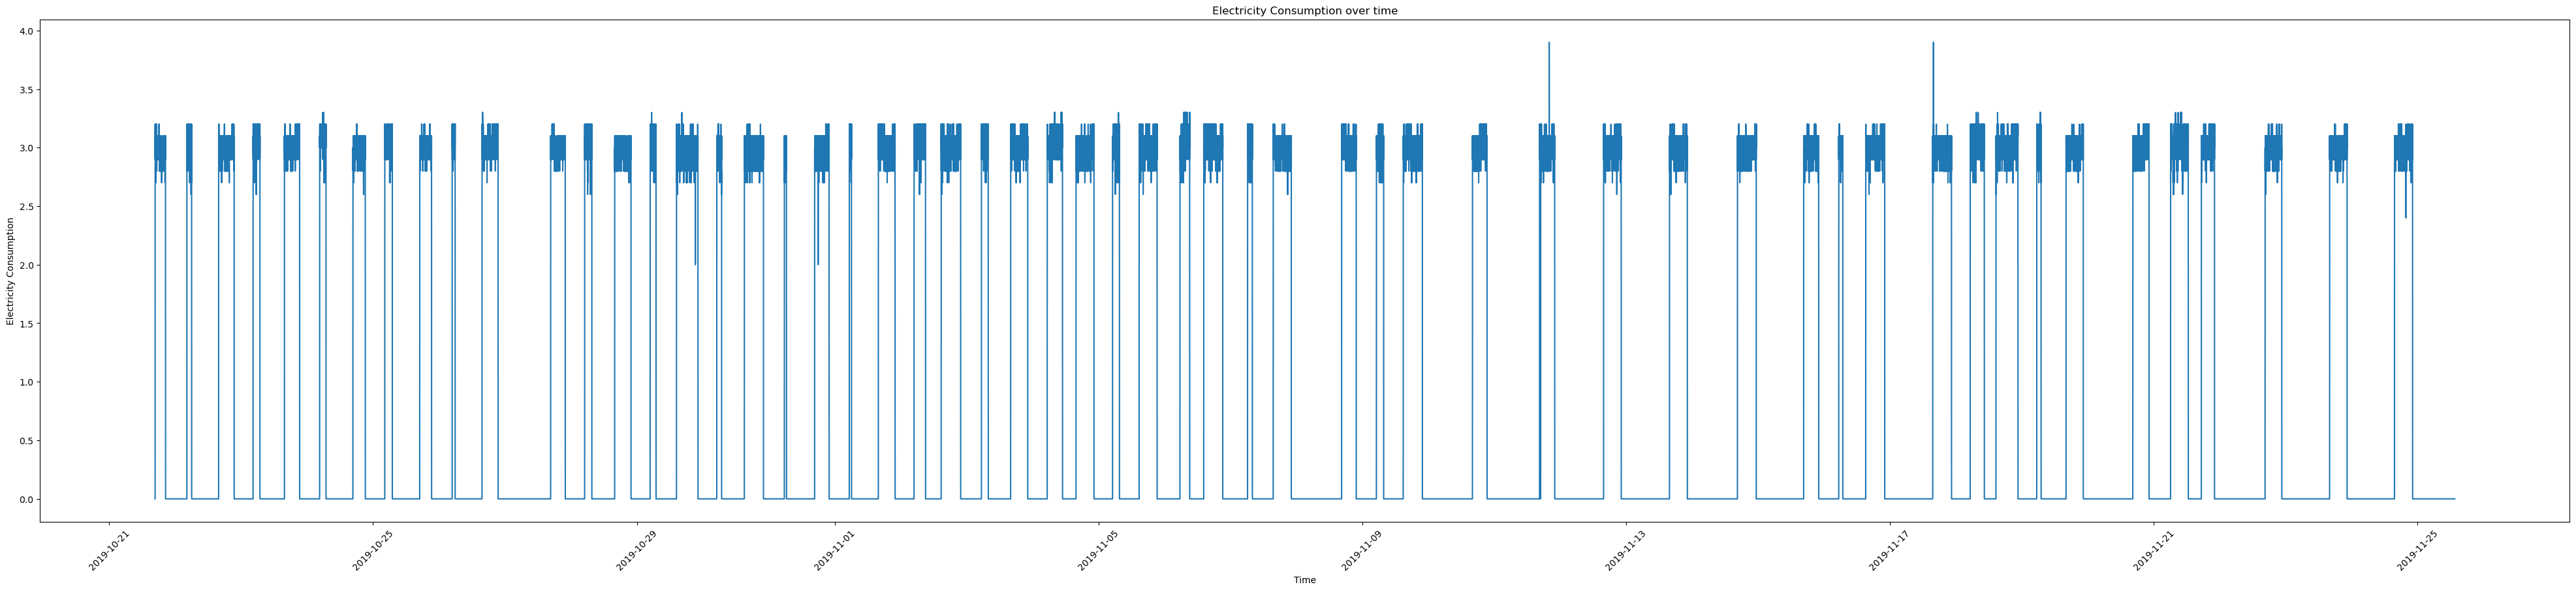

In [73]:
plt.figure(figsize=(50,10))
plt.plot(df_fl['time'], df_fl['floor_lamp_electricity_consumption'])
plt.xlabel('Time')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption over time')
plt.xticks(rotation=45)
plt.show()

### 5min avg

In [74]:
df_fl.set_index('time', inplace = True)
df_fl_5avg = df_fl.resample('5T').mean()
df_fl_5avg.reset_index(inplace = True)

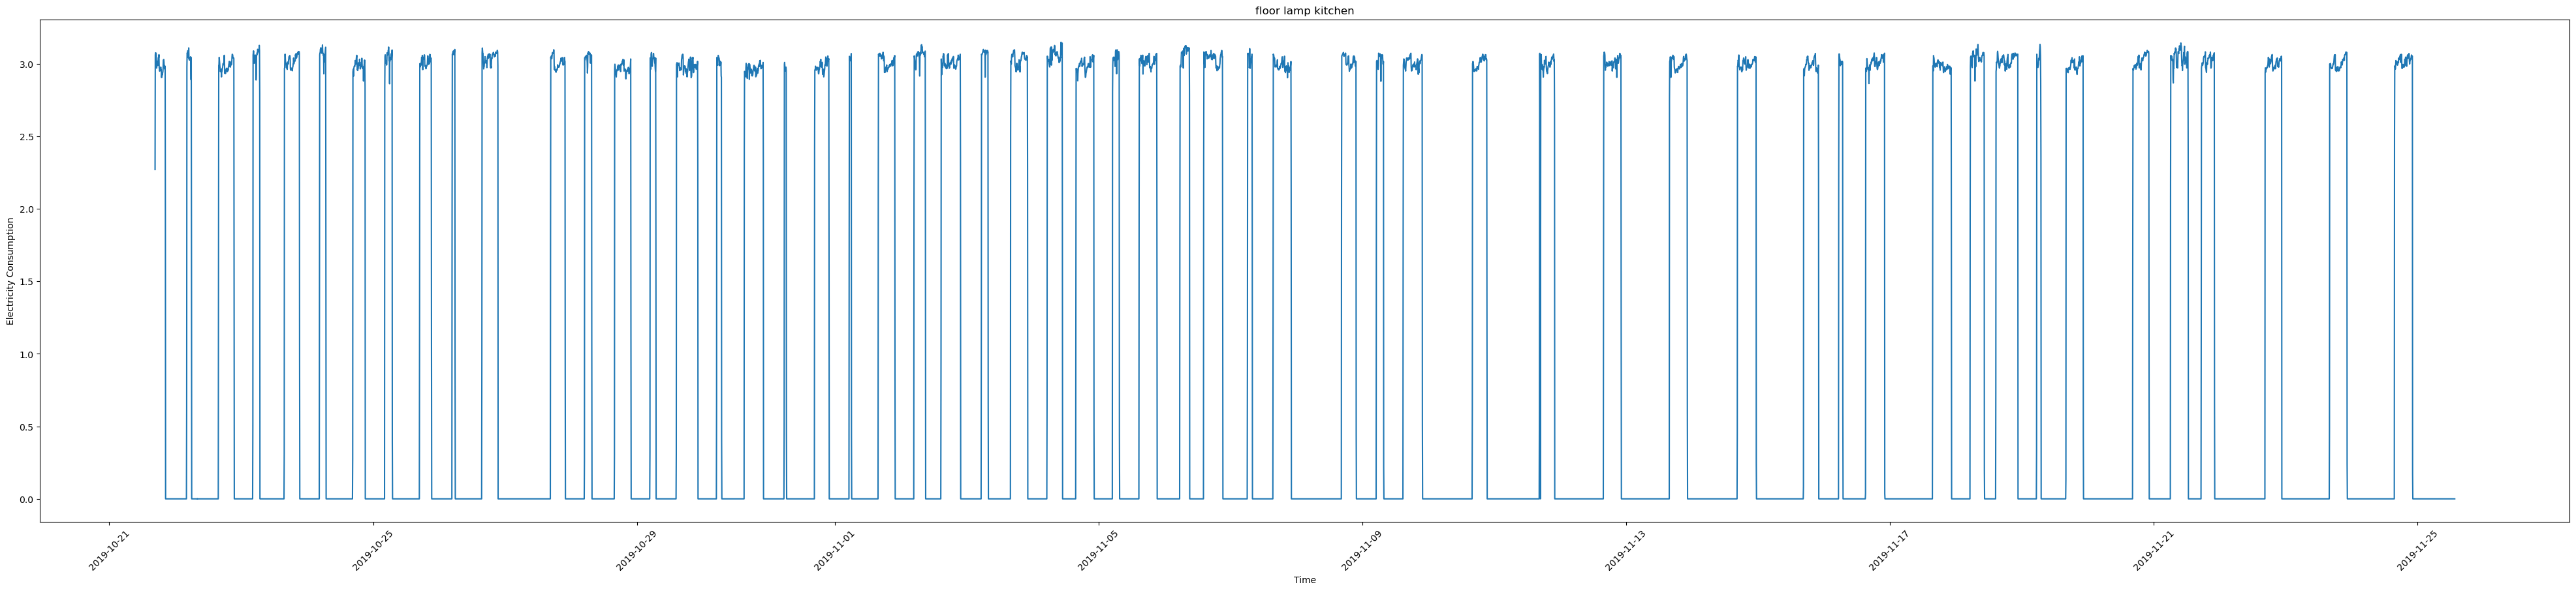

In [76]:
plt.figure(figsize=(50,10))
plt.plot(df_fl_5avg['time'], df_fl_5avg['floor_lamp_electricity_consumption'])
plt.xlabel('Time')
plt.ylabel('Electricity Consumption')
plt.title('floor lamp kitchen')
plt.xticks(rotation=45)
plt.show()

In [78]:
df_fl_1022_5avg = df_fl_5avg[df_fl_5avg['time'].dt.date == pd.to_datetime(target_day).date()]

In [79]:
fig = px.line(df_fl_1022_5avg, x='time', y='floor_lamp_electricity_consumption', title='Floor Lamp Kitchen')
fig.show()

### 60min avg

In [80]:
df_fl_60avg = df_fl.resample('1H').mean()
df_fl_60avg.reset_index(inplace = True)

In [81]:
df_fl_1022_60avg = df_fl_60avg[df_fl_60avg['time'].dt.date == pd.to_datetime(target_day).date()]

In [82]:
fig = px.line(df_fl_1022_60avg, x='time', y='floor_lamp_electricity_consumption', title='Floor Lamp Kitchen')
fig.show()

## Televison

In [20]:
df_tv = pd.read_csv("/home/sm04323/GeLapDataset/gelap-master/hh-07/label_008.csv")
df_tv = df_tv.rename(columns={'power': 'tv_electricity_consumption', 'time_reply': 'time'})
df_tv = df_tv.drop(['time_request'], axis=1)
df_tv['time'] = pd.to_datetime(df_tv['time'], unit='ms')

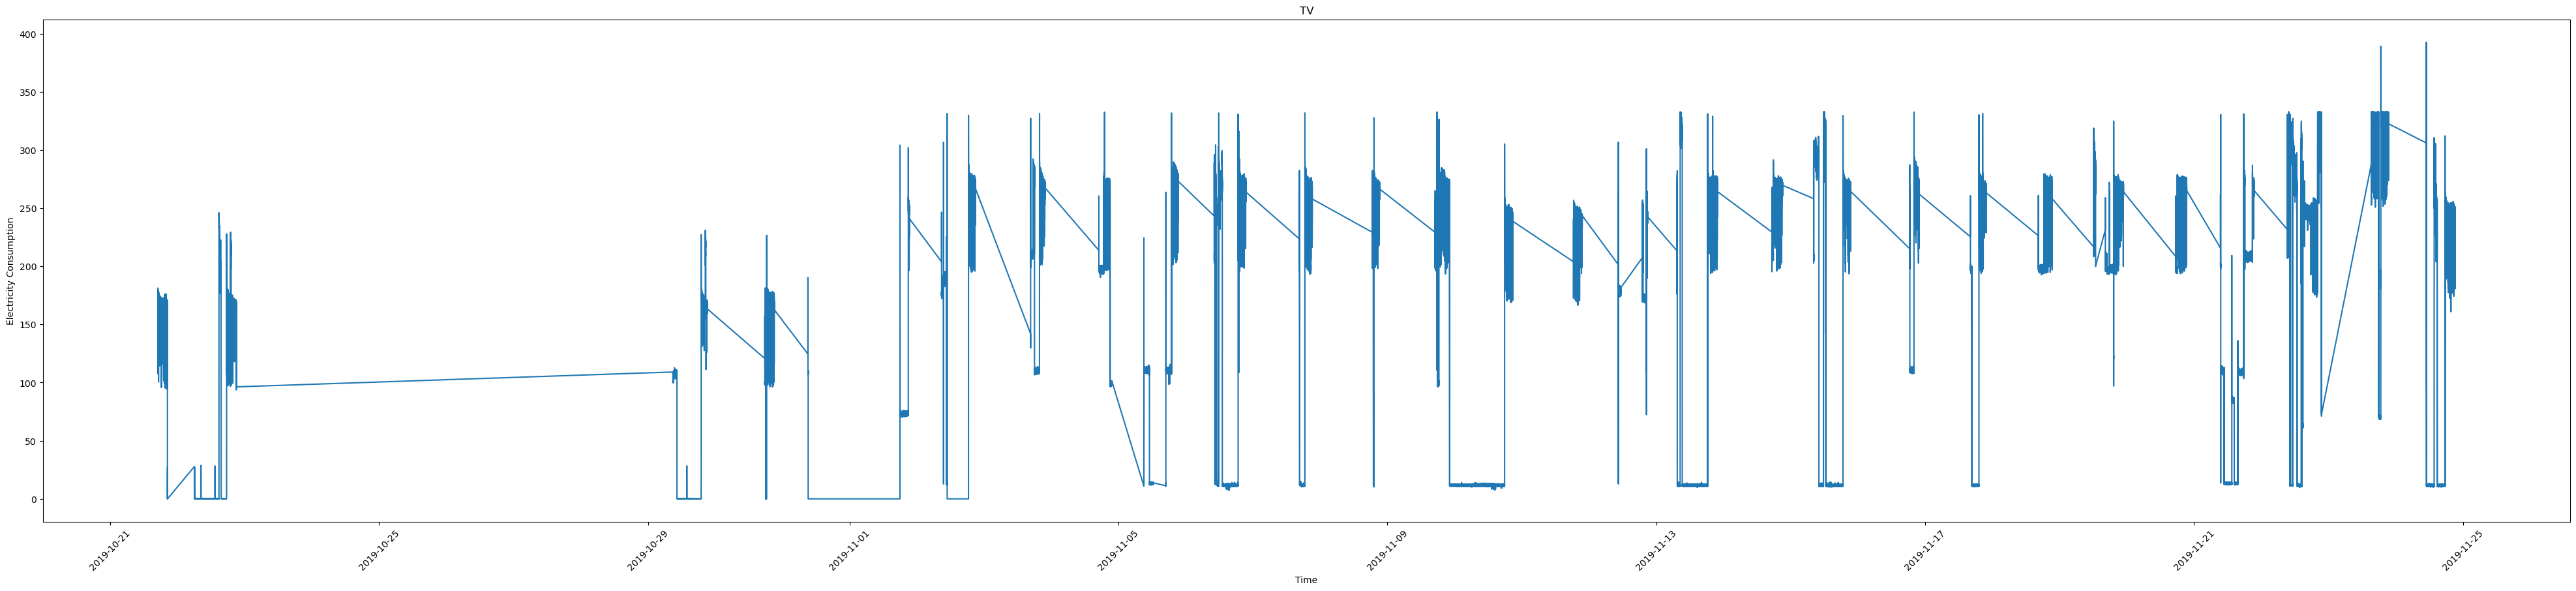

In [21]:
plt.figure(figsize=(50,10))
plt.plot(df_tv['time'], df_tv['tv_electricity_consumption'])
plt.xlabel('Time')
plt.ylabel('Electricity Consumption')
plt.title('TV')
plt.xticks(rotation=45)
plt.show()

## floor lamp living room

In [22]:
df_tv = pd.read_csv("/home/sm04323/GeLapDataset/gelap-master/hh-07/label_009.csv")
df_tv = df_tv.rename(columns={'power': 'floor_lamp_electricity_consumption', 'time_reply': 'time'})
df_tv = df_tv.drop(['time_request'], axis=1)
df_tv['time'] = pd.to_datetime(df_tv['time'], unit='ms')

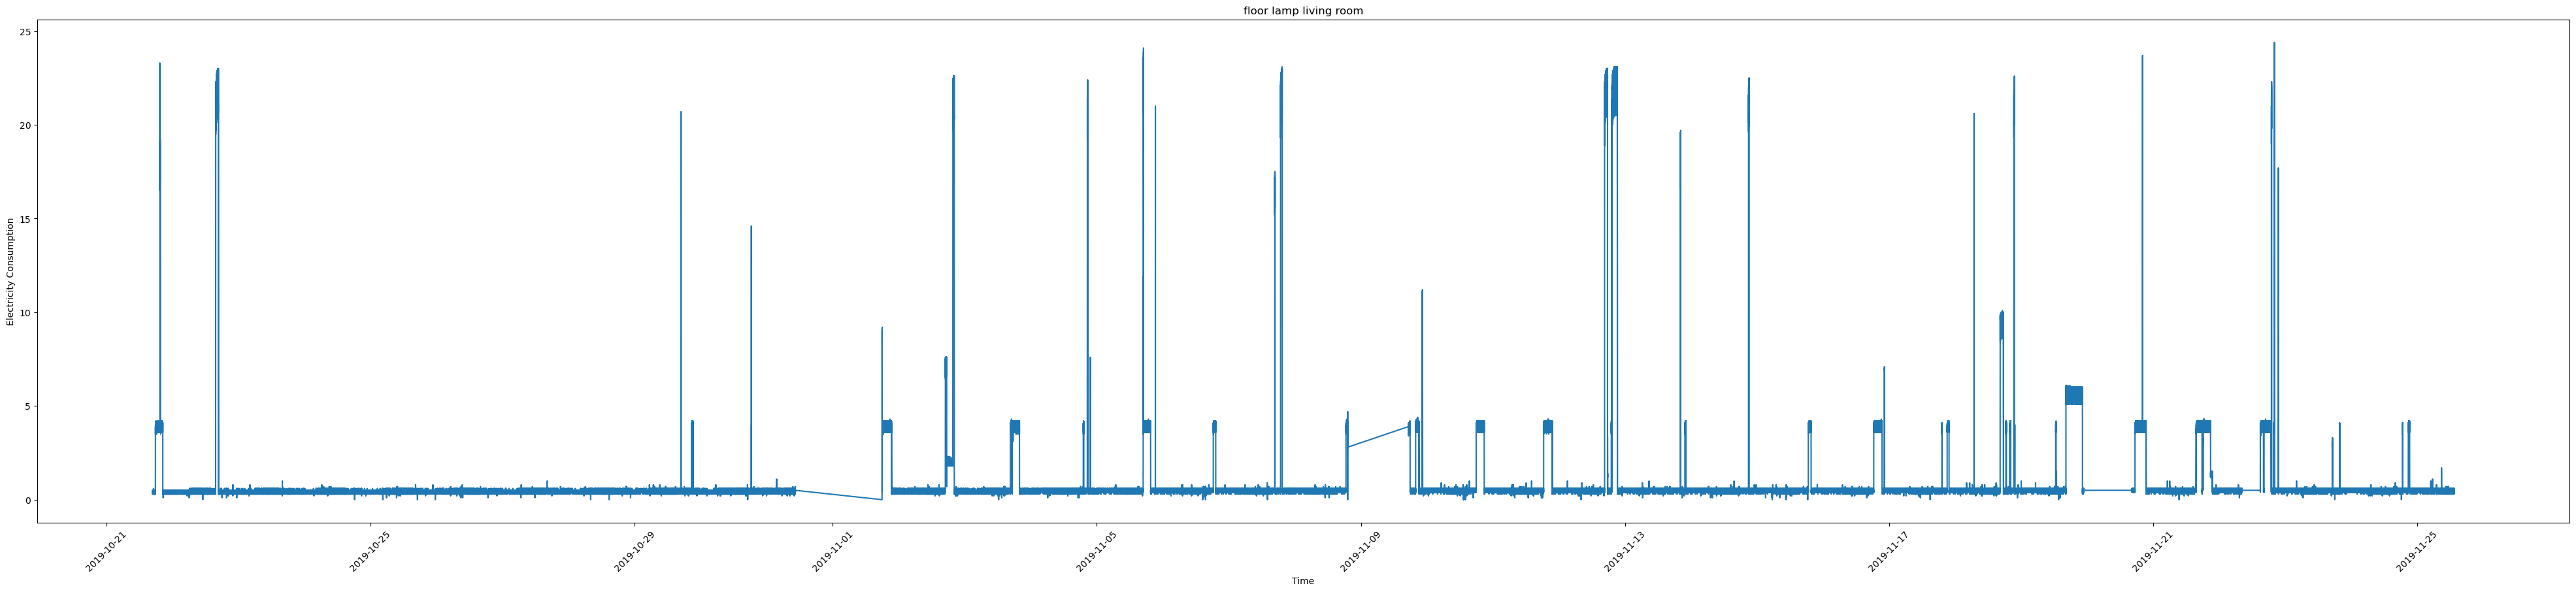

In [23]:
plt.figure(figsize=(50,10))
plt.plot(df_tv['time'], df_tv['floor_lamp_electricity_consumption'])
plt.xlabel('Time')
plt.ylabel('Electricity Consumption')
plt.title('floor lamp living room')
plt.xticks(rotation=45)
plt.show()

## Radio

In [24]:
df_r = pd.read_csv("/home/sm04323/GeLapDataset/gelap-master/hh-07/label_010.csv")
df_r = df_r.rename(columns={'power': 'radio_electricity_consumption', 'time_reply': 'time'})
df_r = df_r.drop(['time_request'], axis=1)
df_r['time'] = pd.to_datetime(df_r['time'], unit='ms')

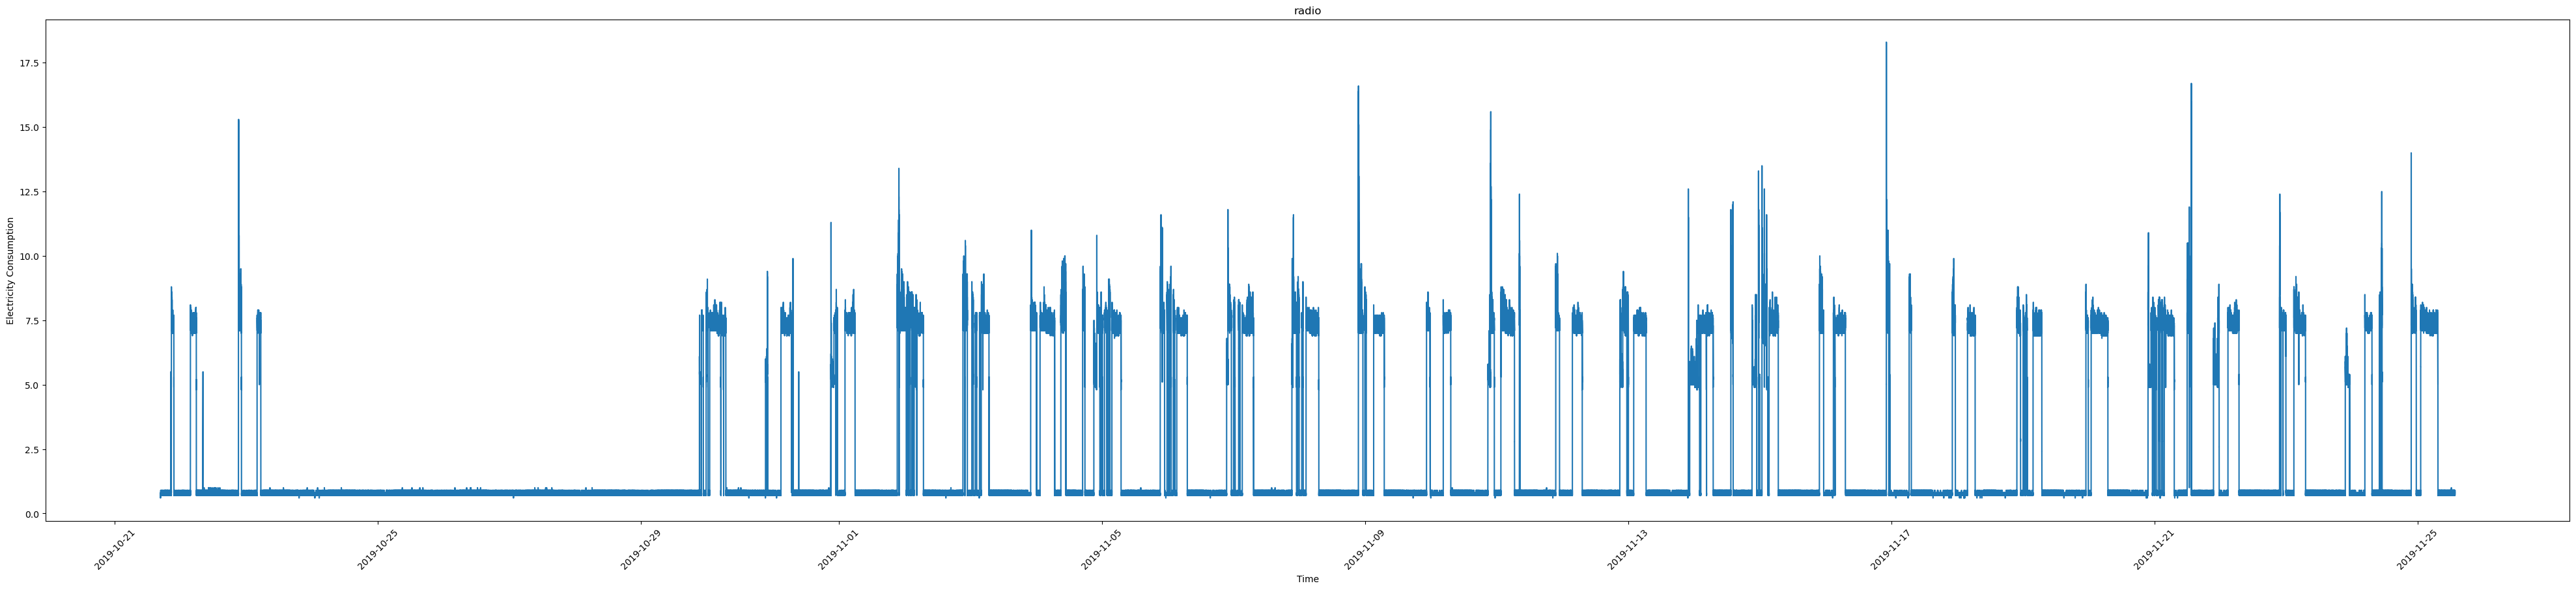

In [25]:
plt.figure(figsize=(50,10))
plt.plot(df_r['time'], df_r['radio_electricity_consumption'])
plt.xlabel('Time')
plt.ylabel('Electricity Consumption')
plt.title('radio')
plt.xticks(rotation=45)
plt.show()